# Twitter exploration
This file shows the following for some of the players:
- Basic exploration (size, histograms, etc.)
- Non-date Correlations
- plots
- date (timeseries) autocorrelation

<br>

**Here is a summary that holds for all players:**
- There is not a strong correlation between sentiment and likes but:
    - An increase in positive sentiment tends to slightly increase likes
    - Wheareas an increase in negative/neutral sentiment slightly tends to decrease likes
- Obviously there is a negative correlation between the different kinds of sentiment
    - Surprisingly the correlation between neutral-positive is much stronger than neutral-negative.
        - This means that we are more often neutral and negative at the same time than neutral and positive
        - Or that when we are positive, we are much more certain than with other sentiments.
        - This can also be seen in the distributions for negative/positive, where we see many more instances of high positivity than negativity. Note that this can also be a bias of the sentiment model
- There is a strong positive correlation between count (also counting tweets we have not collected) and avg likes per day
    - This means that when there is many tweets mentioning the player in a day, then each individual tweet also gets more likes
        - Makes sense sense more tweets = more engagement = higher probability for likes
        - This seem to be slightly affected by the sentiment, but not very much
- A normal scatterplot shows no trends for the sentiment
- A normal scatterplot shows how likes tends to increase over time
- Autocorrelation plots show that there the biggest trend is for small lags, with no seasonality
    - Meaning that the correlation of "likes" or "avg_postive" with itself is most correlated between 1-day hops
    - these metrics are affected by their nearby dates, e.g. there is a trend that moves over time

<br>
<br>



**Update 20-11-2022** 

More time series analysis has been done.

Tweets are correlated with match performance on the match days

<br>

**Important correlations for tweets on match days (ronaldo examples, but holds for all):**
- rating is correlated with most player stats
- minutes is correlated with most player stats
- **avg_likes:**
    - avg_likes | rating: 0.21
    - avg_likes | goals: 0.3

- **sentiment**:
    - avg_negative/neutral only has negative correlations with stats
        - indicating that a higher number in a stat is always positive (e.g. no negative stats)
    - avg_positive is correlated with many stats
    - avg_positive | minutes: 0.20
    - avg_positive | rating: 0.58
    - avg_positive | shotsOn: 0.39
    - avg_positive | goals: 0.66

- **count**:
    - count | rating: 0.24
    - count | goals: 0.32

- **lag**:
    - When adding lag the correlation is highest at the day of the match
        - The correlation almost immediatly declines
        - The correlation after the match is more important than before

- **CB vs forwards**:
    - Correlation is much higher for forwards in most metrics
    - However, the correlation with rating is similar
        - So it seems the rating captures a similar sentiment for all player positions
    - If we examine the ratings correlation with other metrics:
        - Then rating correlates more with goals and shots for forwards
        - While rating correlates more with tackles and duels for CB


<br>

**Rolling means & seasonality**
- The number of tweets (count) spikes on match days
- avg_positive can drastically change on match days, but inbetween matches it doesn't change much
- There seems to be no clear seasonality for avg_positive
- The trend for avg_positive varies per player
- avg_likes and count increase over the years
- There is seasonality in the count, where it seems to spike at certain times each year

<br>

**missing stuff (maybe nice to add)**:
- time series stationarity
- Combine multiple players rather than looking at them individually
    - Hard to reason about
- Correlation between tweets and matches which are not just based on specific days


In [177]:
import pandas as pd
import pathlib
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pandas.api.indexers import BaseIndexer
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dt


# To surpress dtype warning when important dates in raw tweets - not important here
import warnings
warnings.filterwarnings('ignore')

## Helper methods

In [175]:
# Reads player tweets and cleans up data as necessary
def read_player_tweets(player, raw = False):
    if raw:
        path = os.path.join('data', 'raw', f'Tweets_{player.replace(" ", "_")}.csv')
        df = pd.read_csv(path, parse_dates=['tweet_date'])
        # data cleaning, needed for raw_teets
        df.tweet_date = pd.to_datetime(df.tweet_date, errors='coerce')
        df.dropna(inplace=True)
        df.set_index('tweet_date')
    else:
        path = os.path.join('data', 'aggregated', 'with_counts', f'Aggregated_tweets_{player.replace(" ", "_")}.csv') 
        df = pd.read_csv(path, parse_dates=['date'])
        df.set_index('date')
    df.fillna(0, inplace=True)
    return df
    
# Histograms and overall shapes of the data
def show_basic_exploration(raw, aggregated):
    print(f"raw shape:\n {raw.shape}\n\n")
    print(f"aggregated shape:\n {aggregated.shape}\n\n")
    print(f'raw describe:\n {raw.describe()}\n\n')
    print(f'aggregated describe:\n {aggregated.describe()}\n\n')
    print(f'raw distributions:')
    raw.hist(figsize=(7,7))
    plt.show()
    print(f'aggregated distributions:')
    aggregated.hist(figsize=(10,10))
    plt.show()

# Correlations in the tweet data columns
def show_correlations(raw, aggregated):
    print(f'raw correlations:\n{raw.corr()}\n\n')
    print(f'aggregated corr:\n{aggregated.corr()}\n\n')

# Plotting function that takes dates (x_axis) and a list of y_axis column names to plot
# minmax_scale is if all columns in y_axis should be scaled between [0,1]
def plot_dates(df, x_axis, y_axis, minmax_scale = False, line=False):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=100))
    for y in y_axis:
        data_y = MinMaxScaler().fit_transform(df[[y]]) if minmax_scale else df[y]
        if line:
            plt.plot(df[x_axis], data_y, label=y)
        else:
            plt.scatter(df[x_axis], data_y, label=y, s=[0.3 for i in range(len(df))])
    plt.gcf().autofmt_xdate()
    plt.xticks(rotation=90)
    plt.xlabel(x_axis)
    plt.legend()

# Plotting function for non-dates. 
def plot_non_dates(df, x_axis, y_axis, minmax_scale = False):
    for y in y_axis:
        data_y  = MinMaxScaler().fit_transform(df[y]) if minmax_scale else df[y]
        plt.scatter(df[x_axis], data_y, label=y, s=[0.3 for i in range(len(df))])
    plt.xlabel(x_axis)
    plt.legend()

# Shows the autocorrelation for one column
def auto_correlation(df, feature):
    pd.plotting.autocorrelation_plot(df.loc[:,[feature]])
    plt.title(feature)


In [4]:
# Reads player games and cleans up data as necessary
def read_player_games(player):
    # Cannot navigate to parent directory in notebook the usual way, so we do it the OS-dependant way
    path = f"../datasets_generation/{player}"
    for filename in os.listdir(path):
        if filename.endswith(".csv") and "RAW" not in filename:
            player_games = pd.read_csv(f"{path}/{filename}", parse_dates=['date'])
            player_games['date'] = pd.to_datetime(player_games['date'], utc = True)
            # Somehow some cells are None while others are 0
            player_games = player_games.replace("None", 0)
            # For som games the rating is "-", we drop those rows
            player_games['rating'] = pd.to_numeric(player_games['rating'], errors = 'coerce')
            player_games.dropna(inplace = True)
            player_games = player_games.sort_values(by=['date'])
            return player_games.astype({
                'rating'     : 'Float64',
                'shotsTotal' : 'Float64',
                'shotsOn' : 'Float64',
                'goals' : 'Float64',
                'assists' : 'Float64',
                'tackles' : 'Float64',
                'blocks' : 'Float64',
                'duelsTotal' : 'Float64',
                'duelsWon' : 'Float64',
                'shotsTotal' : 'Float64',
                'foulsDrawn' : 'Float64',
                })

# Returns a dataframe where the dates between tweets and player_games has been joined
# The lag argument specifies whether or not to shift the data, so we can compare correlation with future dates
def match_tweets_with_games(tweets_aggregated, player_games, lag = 0):
    tweets_aggregated['lag_date'] = tweets_aggregated['date'].shift(lag)
    matches_with_tweets = player_games.merge(tweets_aggregated, 'left', left_on="date", right_on='lag_date')
    return matches_with_tweets

# Plots some tweet and games metrics together, prints the correlation,
# and plots the correlation of player stats with avg_positive tweets across a range of lags
def add_games_analysis(player_games, tweets_aggregated):
    # Plot basic exploration with correlation for lag 0
    matches_with_tweets = match_tweets_with_games(tweets_aggregated, player_games, 0)
    plot_dates(matches_with_tweets, 'lag_date', ['rating', 'count', 'avg_likes'], minmax_scale=True)
    plot_dates(matches_with_tweets, 'lag_date', ['rating', 'avg_positive'], minmax_scale=True)
    print(matches_with_tweets.corr())

    # Plot avg_positive correlation with player stats with varying lag.
    # E.g does the tweets before / after games correlate with the performance
    lag_df = pd.DataFrame(columns=['minutes','rating', 'shotsTotal', 'shotsOn', 'goals', 'assists', 'passes', 
    'tackles', 'blocks', 'duelsTotal', 'duelsWon', 'foulsDrawn', 'penaltiesScored'])
    for l in range(-5,5):
        df = match_tweets_with_games(tweets_aggregated, player_games, lag = l)
        lag_df.loc[l] = df.corr()['avg_positive'][1:14]
    lag_df
    lag_df.plot()
    plt.xlabel("Lag")
    plt.ylabel("Corr with avg_positive")
    plt.show()

In [5]:
# Used for computing rolling means
# When using this indexer, the means between subsequent matches are calculated
# Note: Not very efficient
class MatchIndexer(BaseIndexer):
    def get_window_bounds(self, num_values, min_periods, center, closed):
        start = np.empty(num_values, dtype=np.int64)
        end = np.empty(num_values, dtype=np.int64)
        for i in range(num_values):
            previous_matches_indices = self.matches.index[self.matches['date'] <= self.tweets.loc[i]['date']]
            next_matches_indices = self.matches.index[self.matches['date'] > self.tweets.loc[i]['date']]
            if len(previous_matches_indices) == 0:
                start[i] = 0
            else:
                index_start = self.tweets.index[self.tweets['date'] == self.matches.loc[previous_matches_indices[-1]]['date']]
                start[i] = index_start[0]
            if len(next_matches_indices) == 0:
                end[i] = len(end)
            else:
                index_end = self.tweets.index[self.tweets['date'] == self.matches.loc[next_matches_indices[0]]['date']]
                end[i] = index_end[0] - 1
        return start, end

# plotting the different components by decomposing the time series
# Based on exercise code 
def plot_seasonality(tweets_aggregated, col, period):
    decomposition_result = seasonal_decompose(tweets_aggregated[col], model='additive', period=period)
    observed = decomposition_result.observed
    seasonal = decomposition_result.seasonal
    trend = decomposition_result.trend
    resid = decomposition_result.resid

    fig,axs = plt.subplots(6,1,figsize=(8,6))
    axs[0].plot(tweets_aggregated['date'],observed,'-',linewidth=1,label='raw',color='#9FC0DE')
    axs[0].set_ylabel('Signal')
    axs[1].plot(tweets_aggregated['date'],trend,'-',linewidth=1,label='raw',color='#FF985A')
    axs[1].set_ylabel('Trend')
    axs[2].plot(tweets_aggregated['date'],observed-trend,'-',linewidth=1,label='raw',color='#FFC3C3')
    axs[2].set_ylabel('Detrended')
    axs[3].plot(tweets_aggregated['date'],seasonal,'-',linewidth=1,label='raw',color='#89E3CC')
    axs[3].set_ylabel('Seasonality')
    axs[4].plot(tweets_aggregated['date'],resid,'-',linewidth=1,alpha=0.8,label='raw',color='#C580BB')
    axs[4].set_ylabel('Residuals')
    axs[5].plot(tweets_aggregated['date'],trend+seasonal,'-',linewidth=1,alpha=0.5,label='raw',color='black')
    axs[5].set_ylabel('Trend + \nSeason')         
    plt.tight_layout()
    plt.show()

# Overall function to be used for displaying all rolling means and seasonality plots
def show_rolling_means_and_seasonality(tweets_aggregated, player_games):
    indexer = MatchIndexer(tweets=tweets_aggregated, matches=player_games)
    mean_by_matches = tweets_aggregated.rolling(indexer).mean()
    mean_by_matches['date'] = tweets_aggregated['date']
    print("Rolling means by match days")
    plot_dates(mean_by_matches, 'date', ['avg_likes', 'count', 'avg_positive'], line=True, minmax_scale=True)

    days_30 = tweets_aggregated.rolling(window=30, min_periods=1,win_type='boxcar',center=False).mean()
    days_30['date'] = tweets_aggregated['date']
    print("Trailing means by 30 days")
    plot_dates(days_30, 'date', ['avg_likes', 'count', 'avg_positive'], line=True, minmax_scale=True)
    print("30 days seasonality for count")
    plot_seasonality(tweets_aggregated, 'count', 30)
    print("30 days seasonality for avg_positive")
    plot_seasonality(tweets_aggregated, 'avg_positive', 30)

    days_30 = tweets_aggregated.rolling(window=365, min_periods=1,win_type='boxcar',center=False).mean()
    days_30['date'] = tweets_aggregated['date']
    print("Traiing means by 365 days")
    plot_dates(days_30, 'date', ['avg_likes', 'count', 'avg_positive'], line=True, minmax_scale=True)
    print("365 days seasonality for count")
    plot_seasonality(tweets_aggregated, 'count', 365)
    print("365 days seasonality for avg_positive")
    plot_seasonality(tweets_aggregated, 'avg_positive', 365)


In [231]:
# Applies a rolling on a dataframe that contains matches and tweets
# window is the window_size, e.g. how many matches to apply the correlation over
# min_period is how many matches we want as minimum, before we "cut" the ends of the timeseries
# corr_key is the column you want to compute all the correlations for
# It is assumed that window and min_period is uneven and that the window is bigger
def get_rolling_correlation(matches_with_tweets, window = 31, min_periods = 31, corr_key = 'rating'):
    assert window >= min_periods and window % 2 == 1 and min_periods % 2 == 1
    rolling_mean = matches_with_tweets.rolling(window=window, min_periods=min_periods, center=False).mean()
    out = pd.DataFrame(columns=np.append(matches_with_tweets.corr().columns.values, ['date', 'avg_positive_on_day','avg_positive_rolling_mean', 'rating_on_day','rating_rolling_mean']))
    sides = window // 2
    min_sides = min_periods // 2
    for i in range(len(matches_with_tweets)):
        if i - min_sides < 0 or i + min_sides > len(matches_with_tweets) - 1:
            continue
        data = matches_with_tweets.loc[i-sides:i+sides]
        out_i = 0 if pd.isnull(out.index.max()) else out.index.max() + 1
        out.loc[out_i] = np.append(data.corr()[corr_key].values, 
                                    [matches_with_tweets.loc[i]['lag_date'],
                                    matches_with_tweets.loc[i]['avg_positive'],
                                    rolling_mean.loc[i]['avg_positive'],
                                    matches_with_tweets.loc[i]['rating'],
                                    rolling_mean.loc[i]['rating']
                                    ])
    return out

# Plots the rolling correlation with vertical lines at the dates of events.
# events is assumed to be a dict(datetime, string)
# keys are the time of events and values are event descriptions
def plot_rolling_correlation_with_events(rolling_corr, events, corr_key = ['avg_positive'], minmax_scale=True):
    plot_dates(rolling_corr, 'date', corr_key, line=True, minmax_scale=minmax_scale)
    for k,v in events.items():
        plt.axvline(k, c='red')
    plt.show()

In [173]:
# Main function to be used for plotting all the analysis in this document for a player
def do_player_tweets_analysis(player):
    tweets_raw = read_player_tweets(player, raw = True)
    tweets_aggregated = read_player_tweets(player, raw = False)
    player_games = read_player_games(player)
    
    show_basic_exploration(tweets_raw, tweets_aggregated)
    show_correlations(tweets_raw, tweets_aggregated)
    plt.show()

    plot_dates(tweets_aggregated, "date", ["count", "avg_likes"])
    plt.show()
    plot_dates(tweets_aggregated, "date", ["avg_negative", "avg_neutral", "avg_positive"])
    plt.show()
    plot_dates(tweets_raw, "tweet_date", ["likes"])
    plt.show()
    plot_non_dates(tweets_raw, "positive", ["negative"])
    plt.show()
    
    auto_correlation(tweets_aggregated, 'avg_likes')
    auto_correlation(tweets_aggregated, 'count')
    auto_correlation(tweets_aggregated, 'avg_positive')
    auto_correlation(tweets_aggregated, 'avg_negative')

    add_games_analysis(player_games, tweets_aggregated)
    show_rolling_means_and_seasonality(tweets_aggregated, player_games)


In [185]:
player = 'Cristiano Ronaldo'
tweets_aggregated = read_player_tweets(player, raw = False)
player_games = read_player_games(player)
matches_with_tweets = match_tweets_with_games(tweets_aggregated, player_games)

<AxesSubplot:>

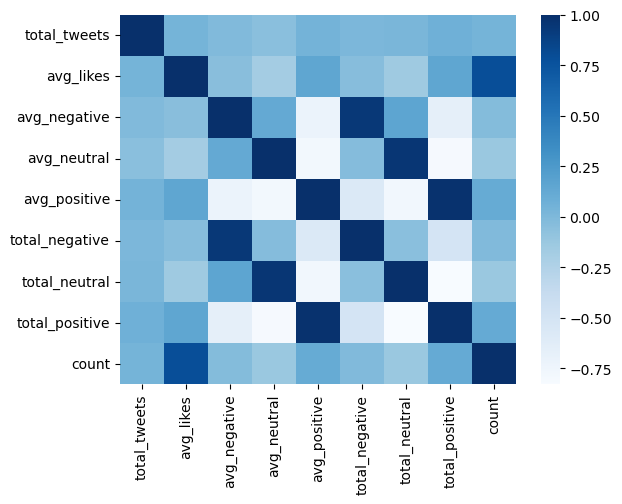

In [240]:
# THIS IS A TEMPORARY LOCATION - MAKE ALL CORRELATION-PLOTS LIKE THIS
import seaborn as sns

test = tweets_aggregated.corr()
sns.heatmap(test, 
        xticklabels=test.columns,
        yticklabels=test.columns, cmap="Blues")

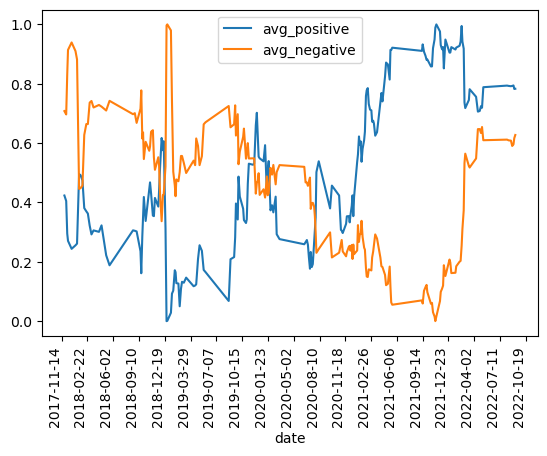

In [234]:
# THIS IS A TEMPORARY LOCATION - MAKE correlation plots with events similar to this
events = {
    dt.datetime(2017, 7, 15): 'charged with fraud',
    dt.datetime(2017, 4, 15): 'investigated for rape',
    dt.datetime(2018, 6, 15): 'two-year suspended jail sentence',
    dt.datetime(2019, 7, 15): "prosecutors won't charge",
    dt.datetime(2021, 10, 15): 'recommendation to dismiss lawsuit',
    dt.datetime(2022, 6, 15): 'rape lawsuit dismissed',
}
events = {}

rolling_correlation = get_rolling_correlation(matches_with_tweets, 35, 11)
plot_rolling_correlation_with_events(rolling_correlation, events, corr_key=['avg_positive', 'avg_negative'])

## Christiano Ronaldo
Here is a summary for the below plots.
- We have collected 380.480 tweets mentioning the player
- On the average day we have collected 199.8 tweets
- The average day has 1099 tweets mentioning the player
- Mean likes are ~514
- Average sentiment is: 
    - 0.14% negative 
    - 0.51% neutral 
    - 0.33% positive
- A normal scatterplot shows no trends for the sentiment
- A normal scatterplot shows how likes tends to increase over time
- Autocorrelation plots show that there the biggest trend is for small lags, with no seasonality
    - Meaning that the correlation of "likes" or "avg_postive" with itself is most correlated between 1-day hops

raw shape:
 (380480, 8)


aggregated shape:
 (1904, 11)


raw describe:
                likes       negative        neutral       positive
count  380480.000000  380480.000000  380480.000000  380480.000000
mean      514.804849       0.145678       0.515861       0.338461
std      3539.646672       0.211424       0.265361       0.314661
min         0.000000       0.000609       0.005156       0.001717
25%         1.000000       0.009919       0.300624       0.068111
50%         9.000000       0.039778       0.544351       0.201003
75%        70.000000       0.198649       0.744119       0.599483
max    594061.000000       0.982081       0.955493       0.993567


aggregated describe:
        total_tweets     avg_likes  avg_negative  avg_neutral  avg_positive  \
count   1904.000000   1904.000000   1904.000000  1904.000000   1904.000000   
mean     199.837710    514.419783      0.145682     0.515890      0.338428   
std        1.749837   1009.465067      0.052325     0.057956      0.082844 

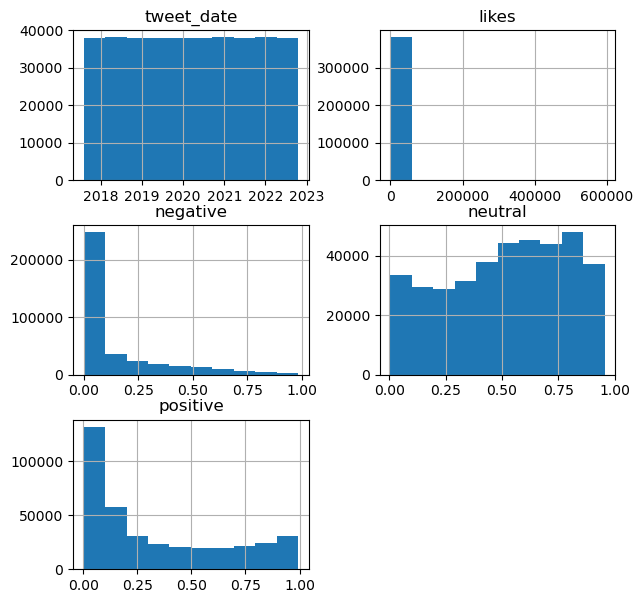

aggregated distributions:


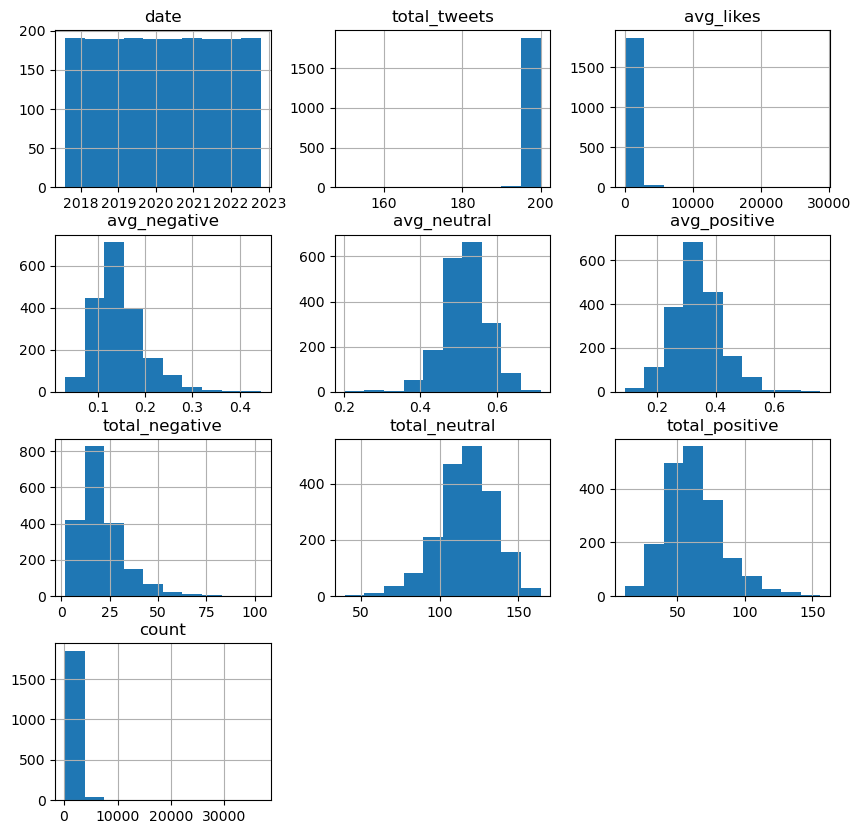

raw correlations:
             likes  negative   neutral  positive
likes     1.000000 -0.022402 -0.019525  0.031518
negative -0.022402  1.000000 -0.143531 -0.550868
neutral  -0.019525 -0.143531  1.000000 -0.746884
positive  0.031518 -0.550868 -0.746884  1.000000


aggregated corr:
                total_tweets  avg_likes  avg_negative  avg_neutral  \
total_tweets        1.000000   0.041908     -0.011078    -0.055001   
avg_likes           0.041908   1.000000     -0.046820    -0.172197   
avg_negative       -0.011078  -0.046820      1.000000     0.126368   
avg_neutral        -0.055001  -0.172197      0.126368     1.000000   
avg_positive        0.045474   0.150037     -0.720005    -0.779391   
total_negative      0.008881  -0.037421      0.936200    -0.031767   
total_neutral       0.015143  -0.147808      0.162569     0.953337   
total_positive      0.065758   0.151457     -0.660007    -0.807385   
count               0.040490   0.789219     -0.027442    -0.128333   

                a

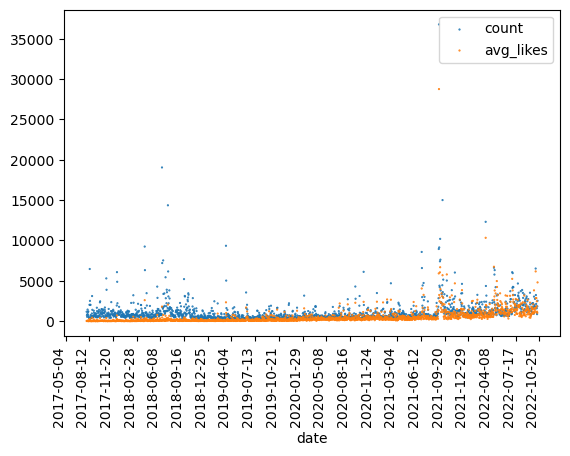

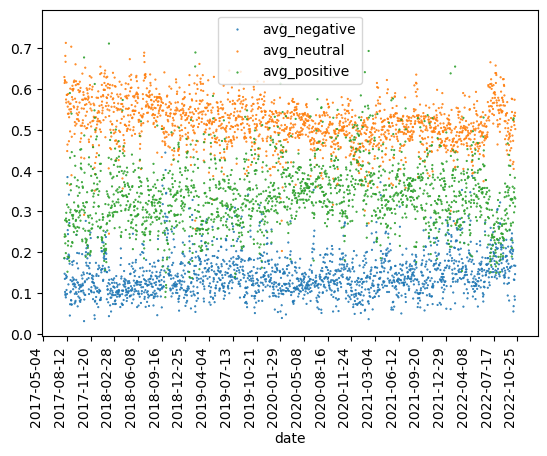

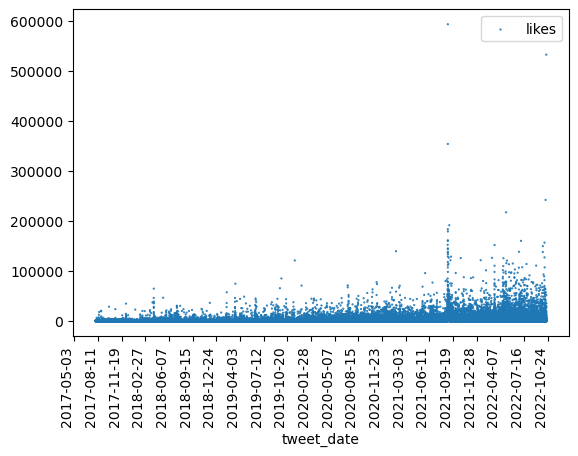

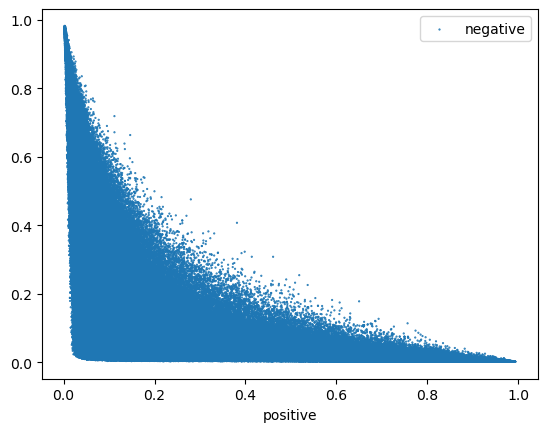

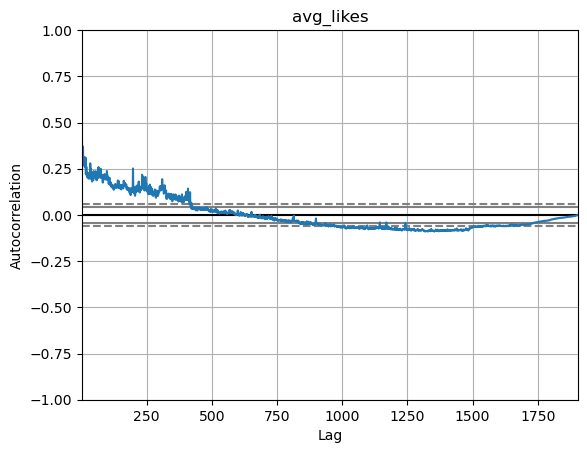

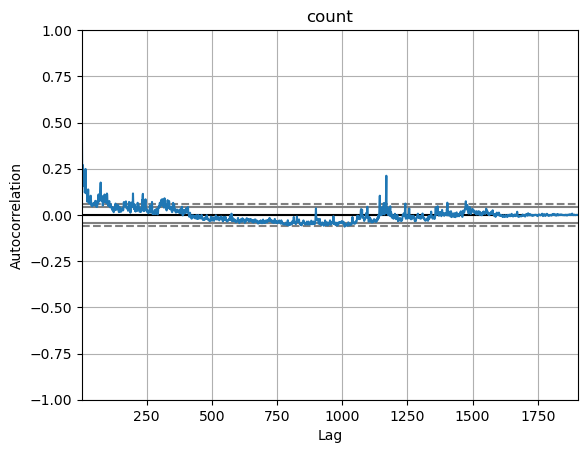

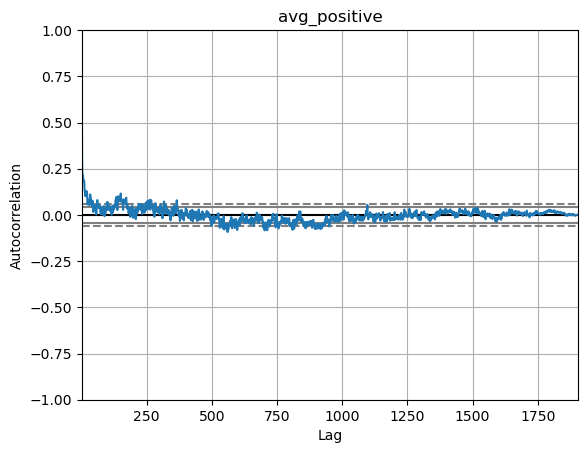

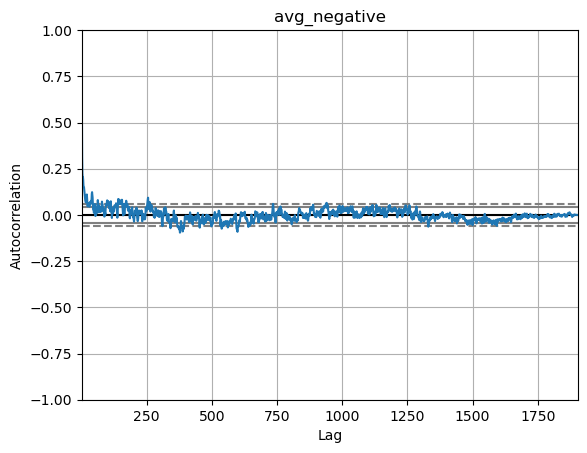

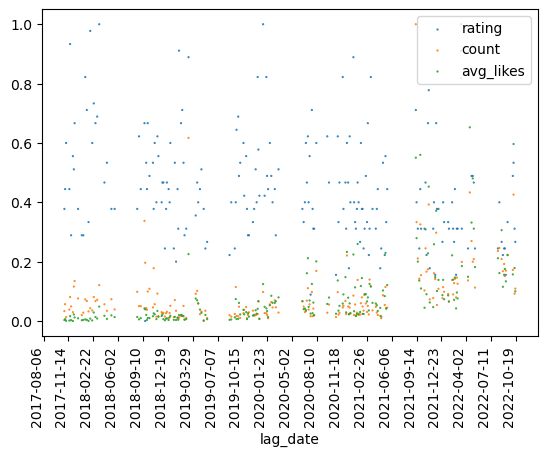

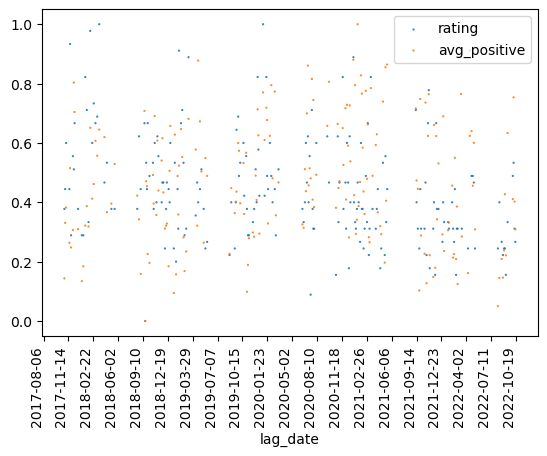

                 Unnamed: 0   minutes    rating  shotsTotal   shotsOn  \
Unnamed: 0         1.000000  0.157717  0.253480    0.471244  0.300319   
minutes            0.157717  1.000000  0.241792    0.386648  0.336728   
rating             0.253480  0.241792  1.000000    0.453676  0.583102   
shotsTotal         0.471244  0.386648  0.453676    1.000000  0.682966   
shotsOn            0.300319  0.336728  0.583102    0.682966  1.000000   
goals              0.136945  0.144438  0.806965    0.307669  0.587224   
assists            0.115351  0.123241  0.364497    0.238774  0.113238   
passes            -0.053856  0.559317  0.282702    0.194423  0.216226   
tackles           -0.086774  0.079429  0.028894   -0.032912 -0.077351   
blocks            -0.006863 -0.060436  0.031735   -0.074681 -0.080621   
duelsTotal         0.044305  0.229063  0.040435   -0.012335  0.021181   
duelsWon           0.095090  0.193506  0.175180   -0.003442  0.017483   
foulsDrawn         0.131973  0.234643  0.131135    

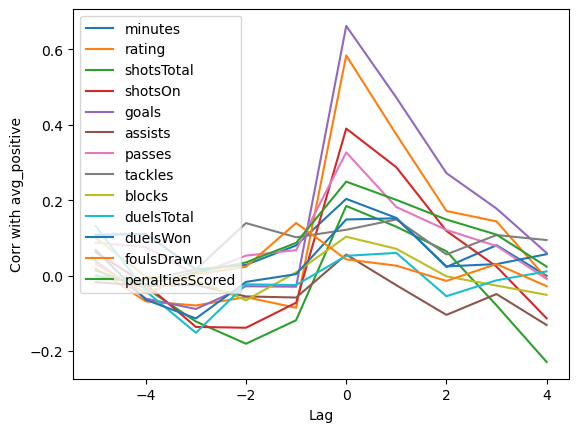

Rolling means by match days


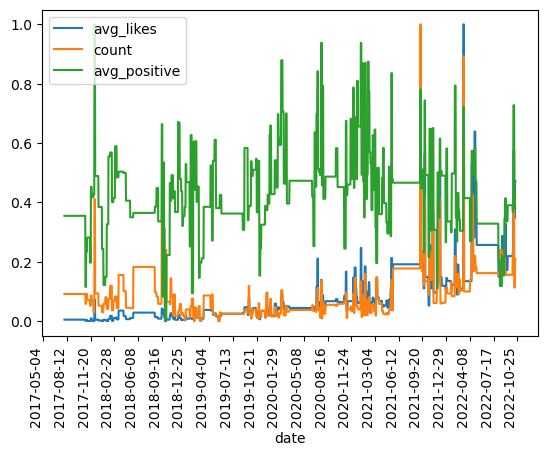

Trailing means by 30 days


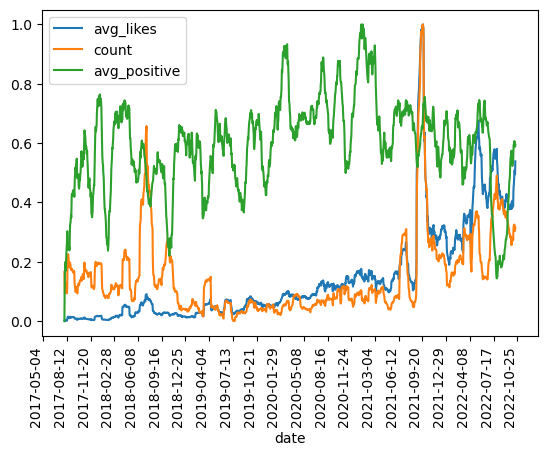

30 days seasonality for count


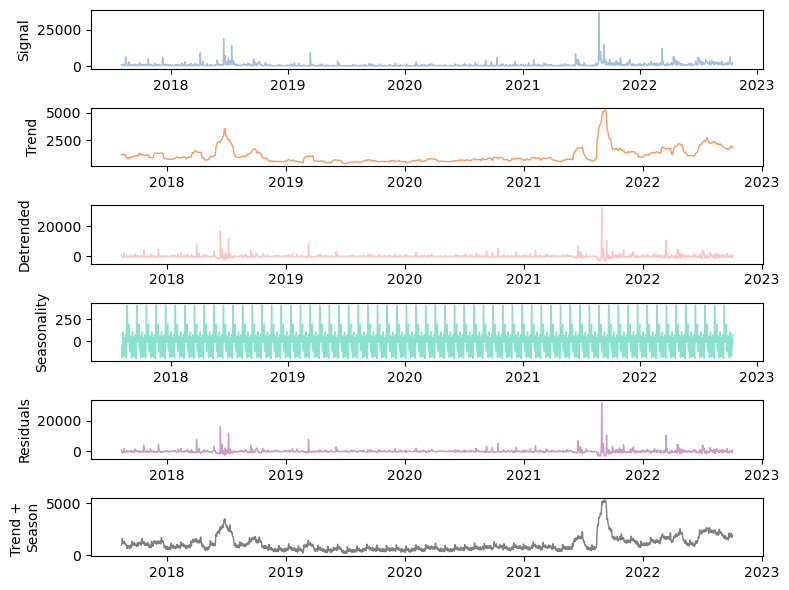

30 days seasonality for avg_positive


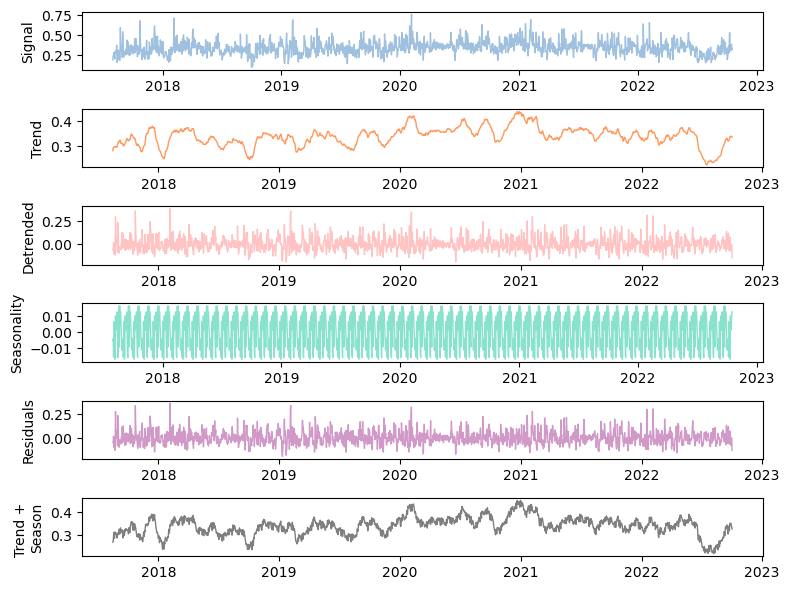

Traiing means by 365 days


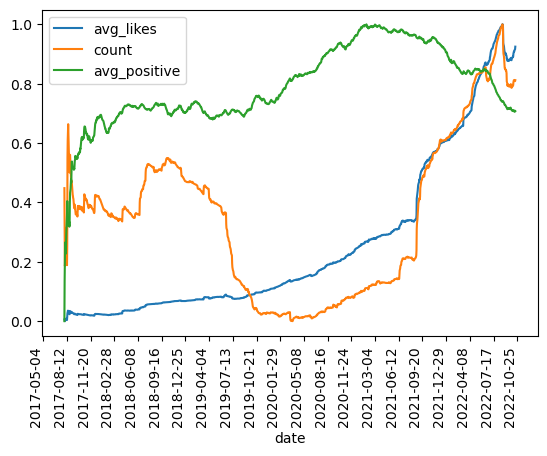

365 days seasonality for count


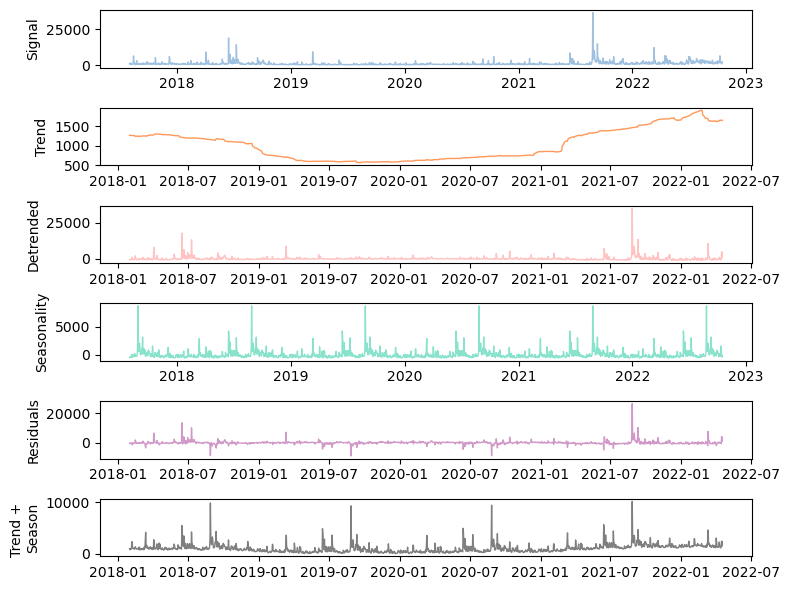

365 days seasonality for avg_positive


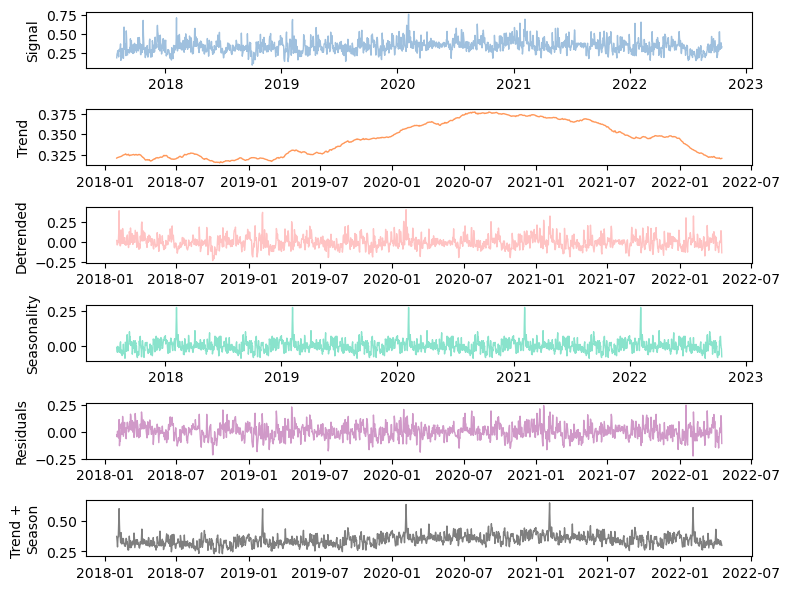

In [22]:
do_player_tweets_analysis("Cristiano Ronaldo")

## Erling Haaland
Here is a summary for the below plots.
- There is a almost no tweets before 2019
- We have collected 144.793 tweets mentioning the player
- On the average day we have collected 76 tweets
- The average day has 177 tweets mentioning the player
- Mean likes are ~320
- Average sentiment is: 
    - 0.14% negative 
    - 0.59% neutral 
    - 0.26% positive

raw shape:
 (144793, 8)


aggregated shape:
 (1904, 11)


raw describe:
                likes       negative        neutral       positive
count  144793.000000  144793.000000  144793.000000  144793.000000
mean      320.756811       0.140091       0.594543       0.265366
std      2898.642538       0.202194       0.269290       0.291176
min         0.000000       0.000614       0.004685       0.002001
25%         0.000000       0.013265       0.395902       0.050179
50%         2.000000       0.045497       0.656041       0.113957
75%        22.000000       0.173421       0.836377       0.421836
max    329200.000000       0.980698       0.963273       0.993346


aggregated describe:
        total_tweets    avg_likes  avg_negative  avg_neutral  avg_positive  \
count   1904.000000  1904.000000   1904.000000  1904.000000   1904.000000   
mean      76.047794   141.751221      0.092118     0.403082      0.216459   
std       81.604015   419.719036      0.085278     0.284597      0.199932   
m

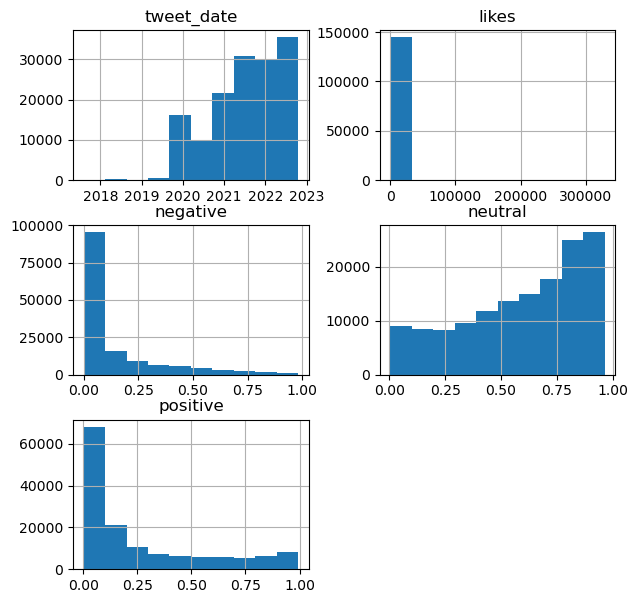

aggregated distributions:


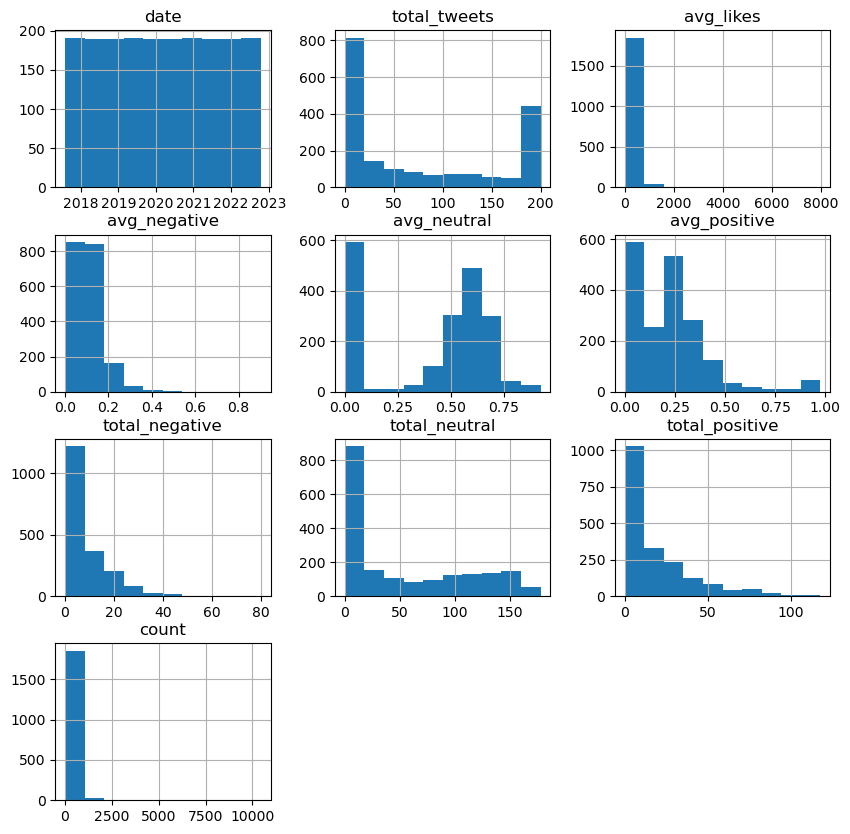

raw correlations:
             likes  negative   neutral  positive
likes     1.000000 -0.012584 -0.019098  0.026401
negative -0.012584  1.000000 -0.262779 -0.451377
neutral  -0.019098 -0.262779  1.000000 -0.742361
positive  0.026401 -0.451377 -0.742361  1.000000


aggregated corr:
                total_tweets  avg_likes  avg_negative  avg_neutral  \
total_tweets        1.000000   0.397651      0.524496     0.627263   
avg_likes           0.397651   1.000000      0.170655     0.179336   
avg_negative        0.524496   0.170655      1.000000     0.661720   
avg_neutral         0.627263   0.179336      0.661720     1.000000   
avg_positive        0.228097   0.159256      0.190223     0.337971   
total_negative      0.797417   0.328025      0.630917     0.468115   
total_neutral       0.976218   0.333655      0.504493     0.650007   
total_positive      0.834651   0.471466      0.364445     0.437927   
count               0.488784   0.921878      0.207436     0.218192   

                a

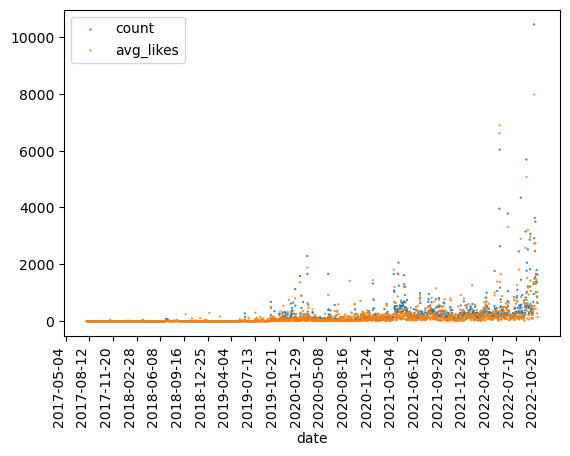

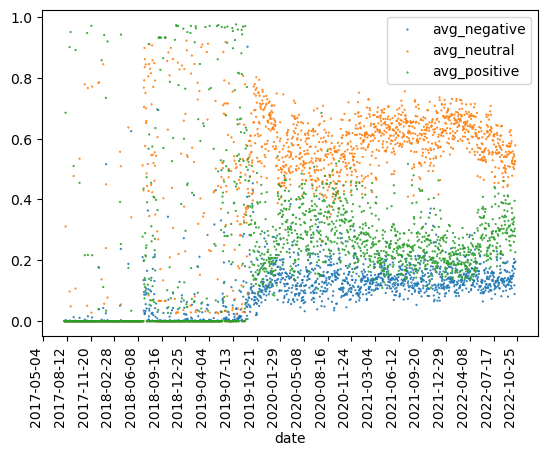

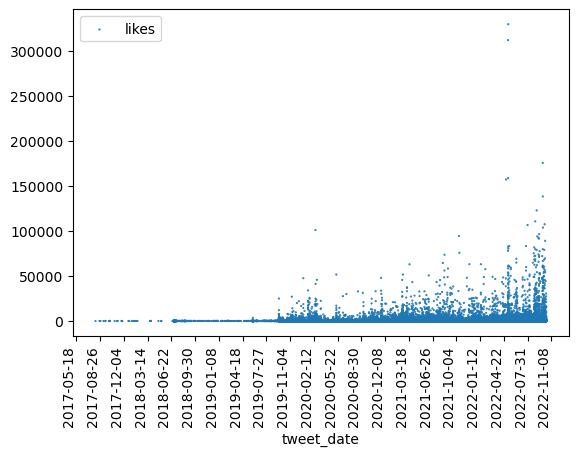

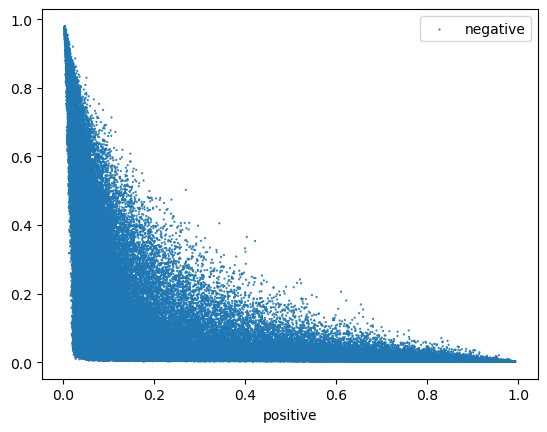

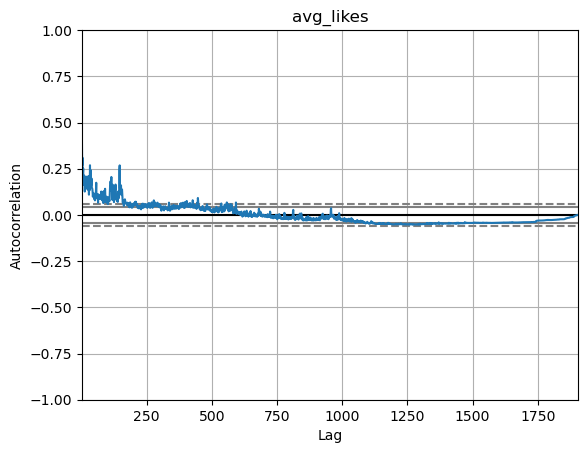

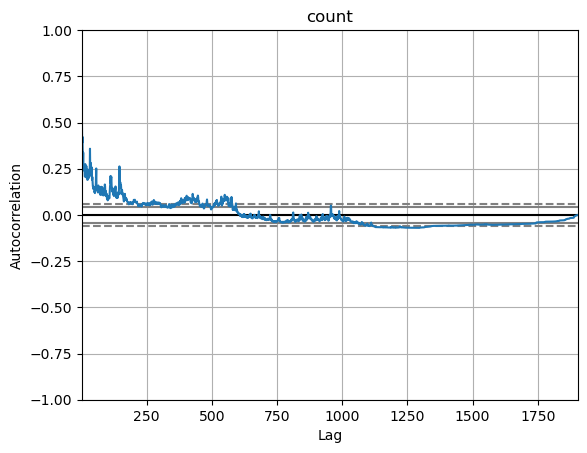

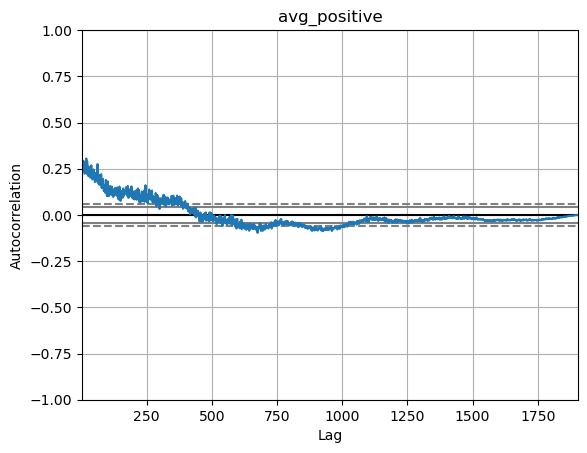

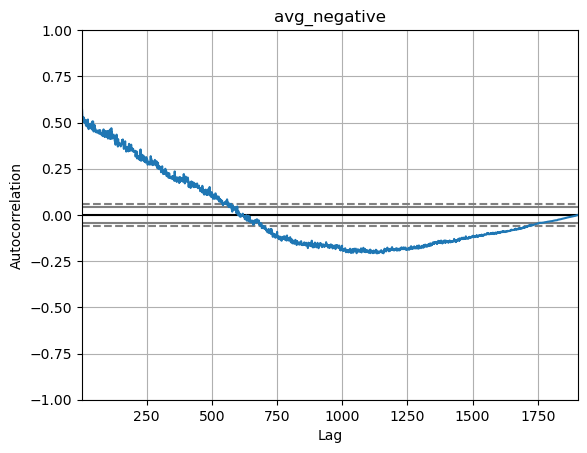

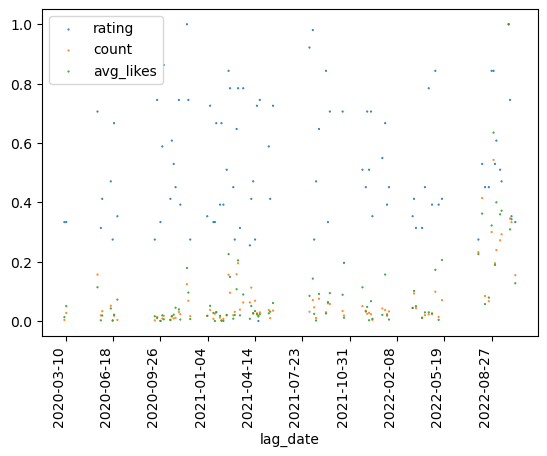

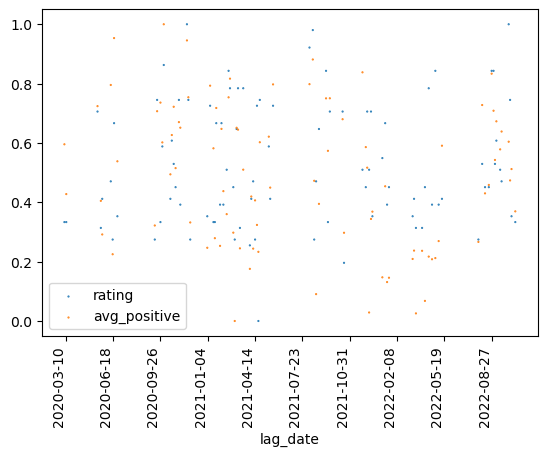

                 Unnamed: 0   minutes    rating  shotsTotal   shotsOn  \
Unnamed: 0         1.000000  0.147064 -0.120844   -0.245973 -0.188713   
minutes            0.147064  1.000000  0.025543    0.136436  0.093258   
rating            -0.120844  0.025543  1.000000    0.508823  0.620571   
shotsTotal        -0.245973  0.136436  0.508823    1.000000  0.810146   
shotsOn           -0.188713  0.093258  0.620571    0.810146  1.000000   
goals             -0.150529  0.001223  0.892068    0.573501  0.694311   
assists           -0.020811  0.106916  0.268339   -0.039687 -0.042738   
passes            -0.021913  0.586136  0.184874    0.197159  0.153847   
tackles            0.139742  0.074197  0.070637   -0.098457 -0.039362   
blocks             0.163227  0.191561  0.137801    0.049408  0.102329   
duelsTotal        -0.074587  0.432455  0.168080    0.400939  0.410639   
duelsWon           0.030980  0.371467  0.252657    0.346492  0.380274   
foulsDrawn         0.135016  0.195121  0.007388    

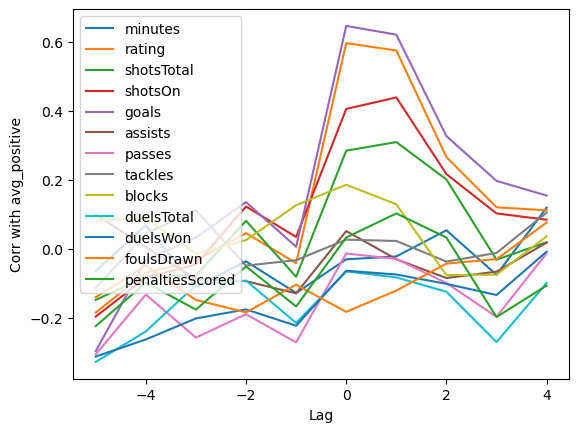

Rolling means by match days


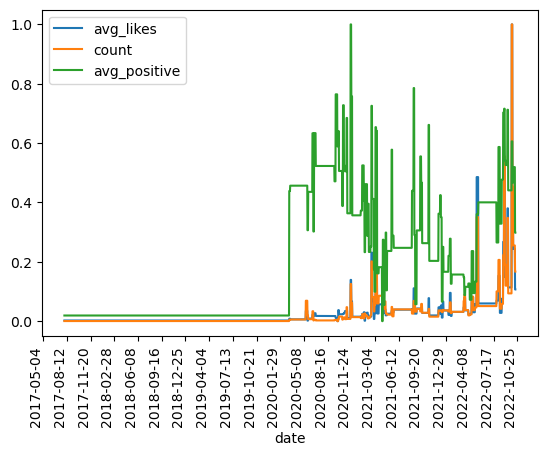

Trailing means by 30 days


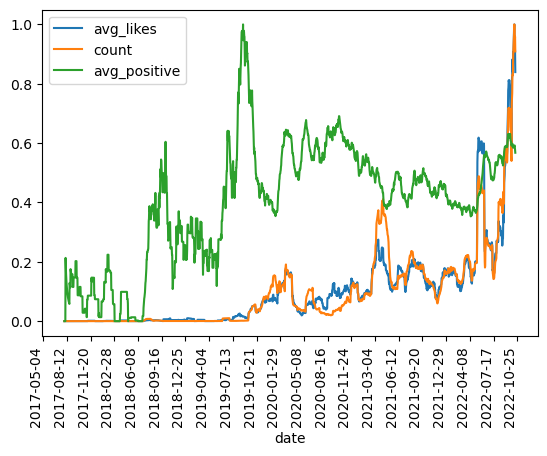

30 days seasonality for count


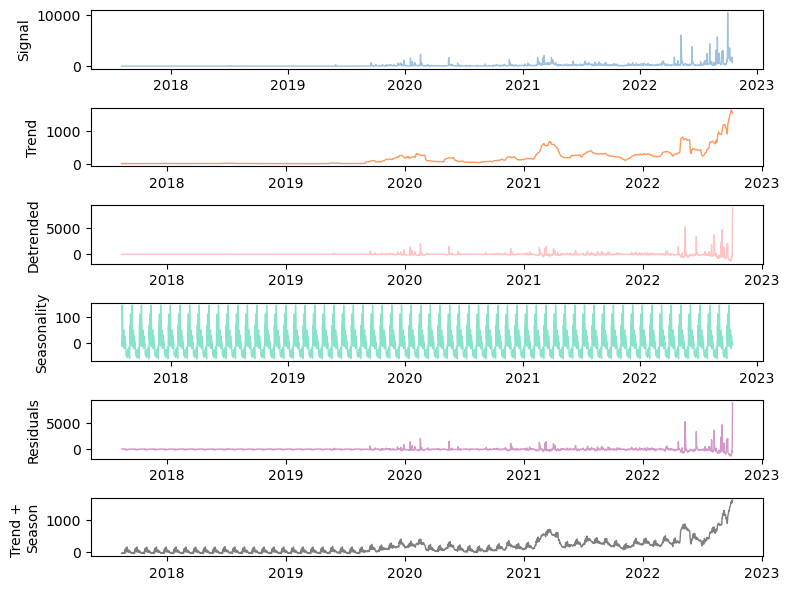

30 days seasonality for avg_positive


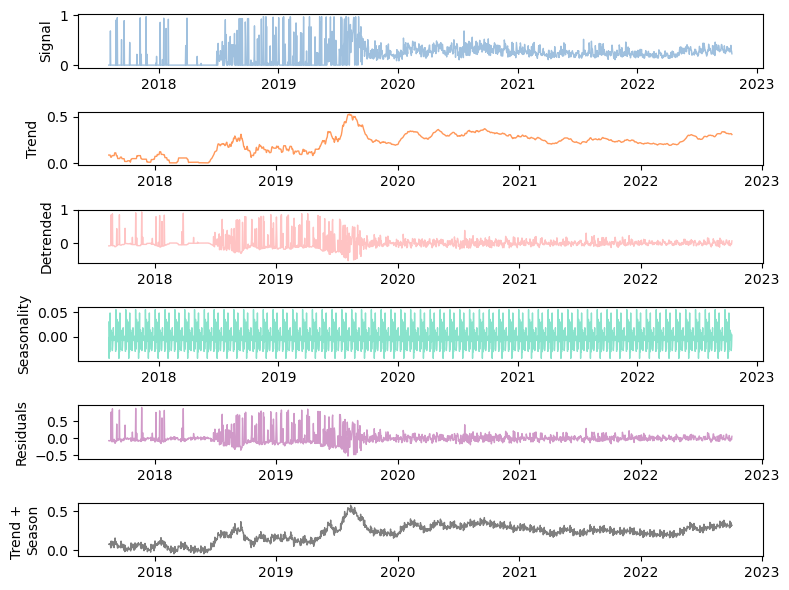

Traiing means by 365 days


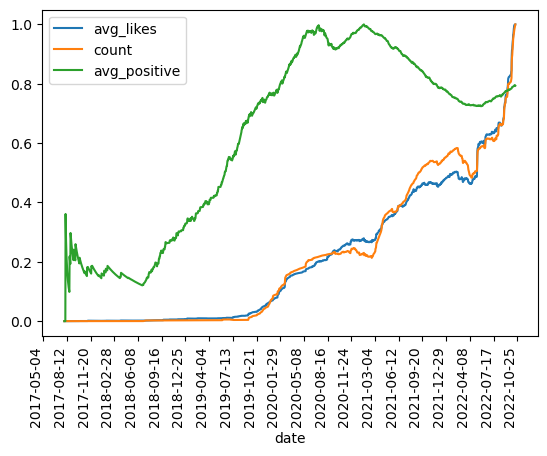

365 days seasonality for count


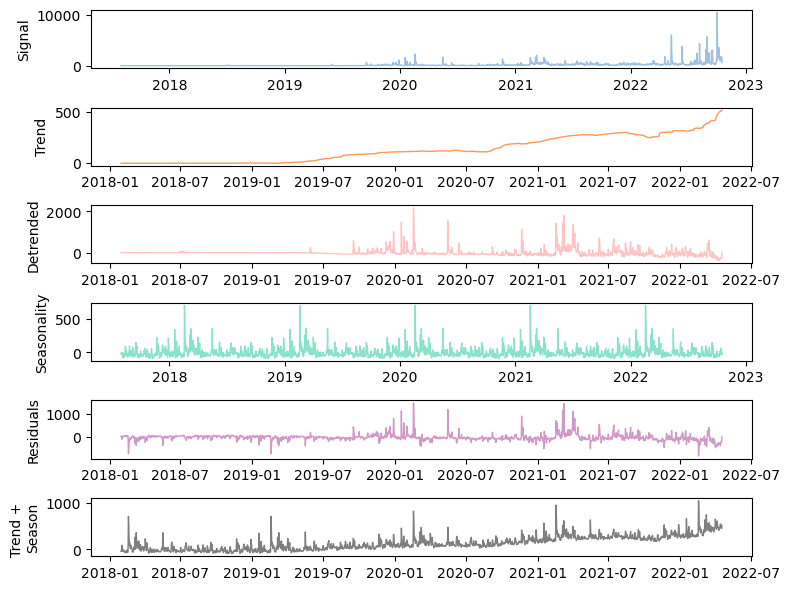

365 days seasonality for avg_positive


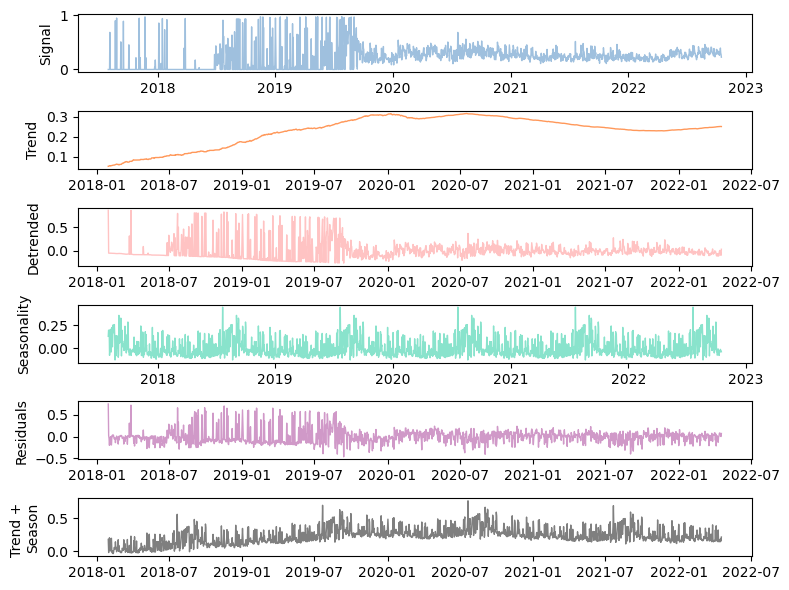

In [23]:
do_player_tweets_analysis("Erling Haaland")

## Sadio Mané

raw shape:
 (225299, 8)


aggregated shape:
 (1904, 11)


raw describe:
                likes       negative        neutral       positive
count  225299.000000  225299.000000  225299.000000  225299.000000
mean      147.629106       0.190264       0.510803       0.298933
std      1917.307035       0.252004       0.280359       0.323100
min         0.000000       0.000596       0.004577       0.001731
25%         0.000000       0.012003       0.268756       0.043410
50%         1.000000       0.062074       0.536976       0.124114
75%         8.000000       0.288130       0.766018       0.543907
max    211444.000000       0.983571       0.959321       0.994076


aggregated describe:
        total_tweets   avg_likes  avg_negative  avg_neutral  avg_positive  \
count   1904.000000  1904.00000   1904.000000  1904.000000   1904.000000   
mean     118.331408   104.64735      0.190269     0.518388      0.291343   
std       63.443629   293.98593      0.077241     0.072177      0.094119   
min  

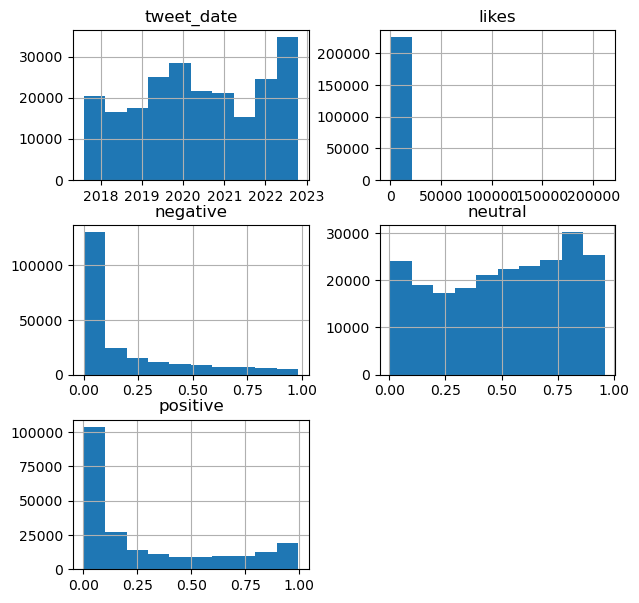

aggregated distributions:


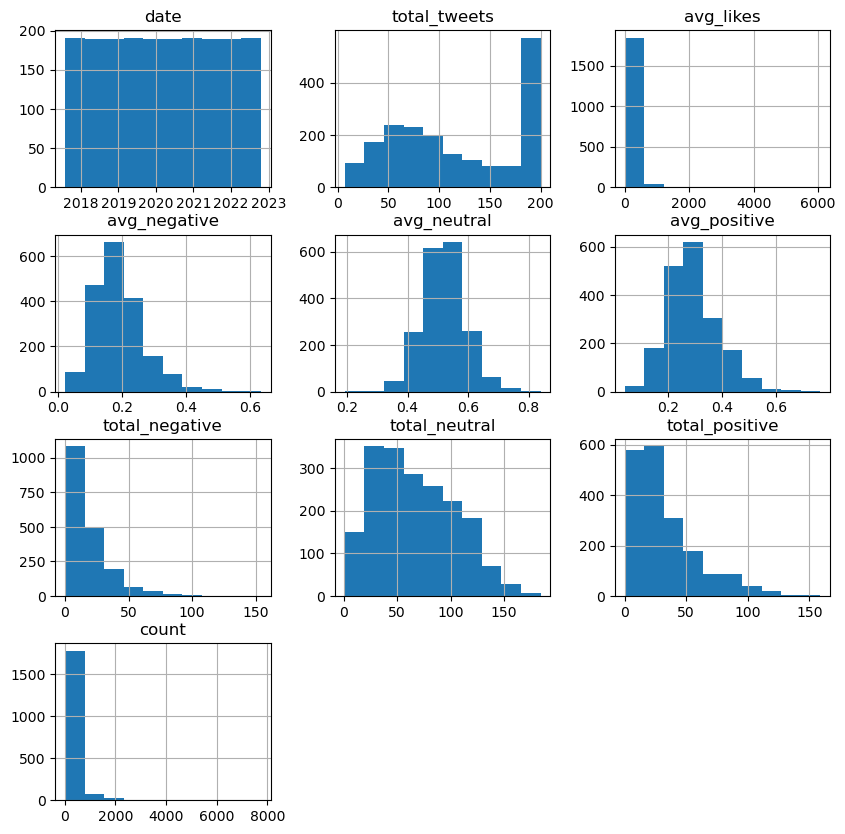

raw correlations:
             likes  negative   neutral  positive
likes     1.000000 -0.026694 -0.013818  0.032810
negative -0.026694  1.000000 -0.266899 -0.548365
neutral  -0.013818 -0.266899  1.000000 -0.659546
positive  0.032810 -0.548365 -0.659546  1.000000


aggregated corr:
                total_tweets  avg_likes  avg_negative  avg_neutral  \
total_tweets        1.000000   0.272819     -0.000110    -0.196037   
avg_likes           0.272819   1.000000     -0.119588    -0.179729   
avg_negative       -0.000110  -0.119588      1.000000    -0.207834   
avg_neutral        -0.196037  -0.179729     -0.207834     1.000000   
avg_positive        0.150426   0.235972     -0.661293    -0.596309   
total_negative      0.587599   0.058699      0.712340    -0.311520   
total_neutral       0.912000   0.188757     -0.060149     0.165626   
total_positive      0.744357   0.356268     -0.389399    -0.505280   
count               0.508384   0.802422     -0.094936    -0.240163   

                a

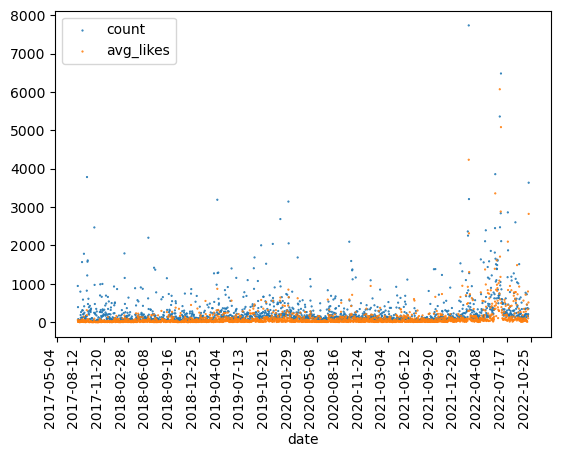

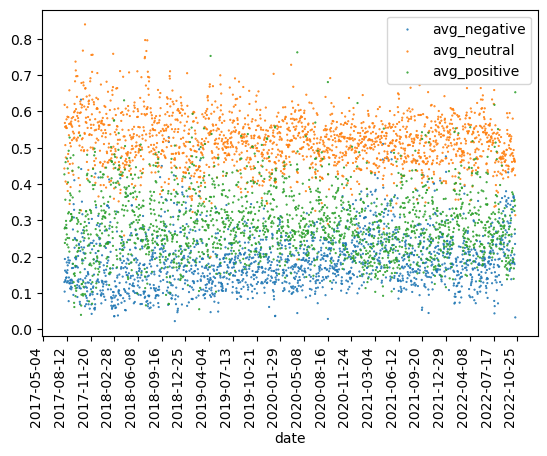

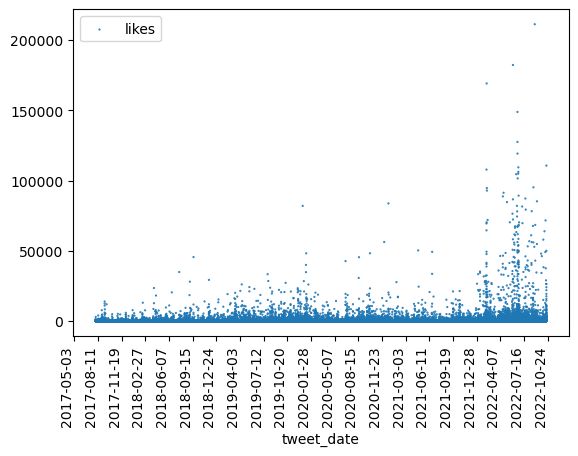

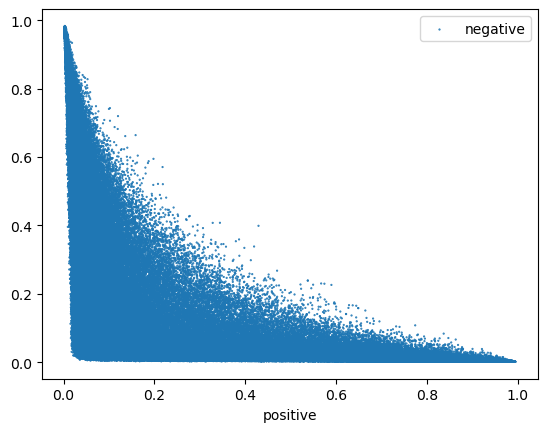

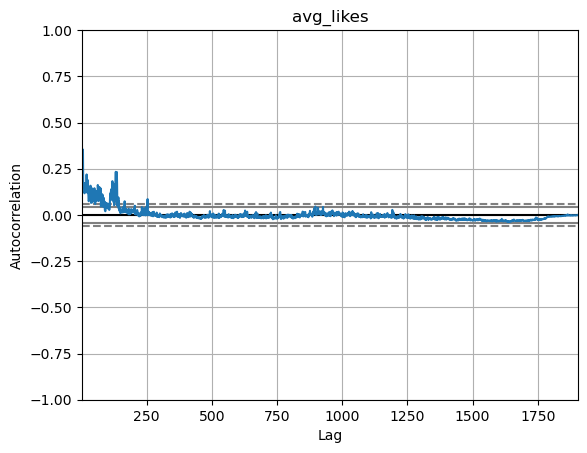

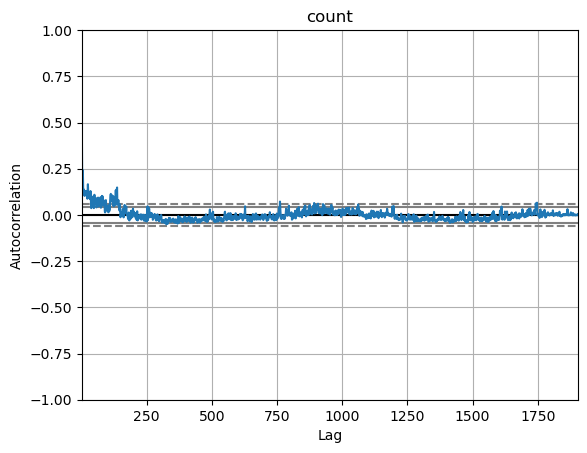

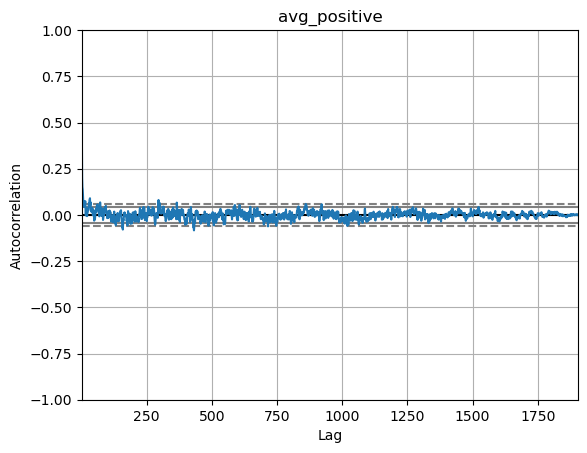

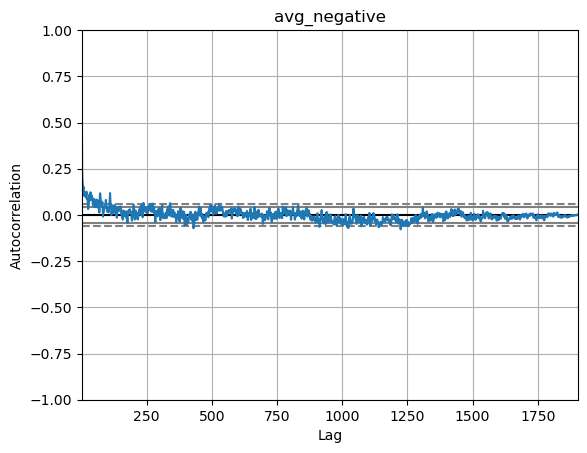

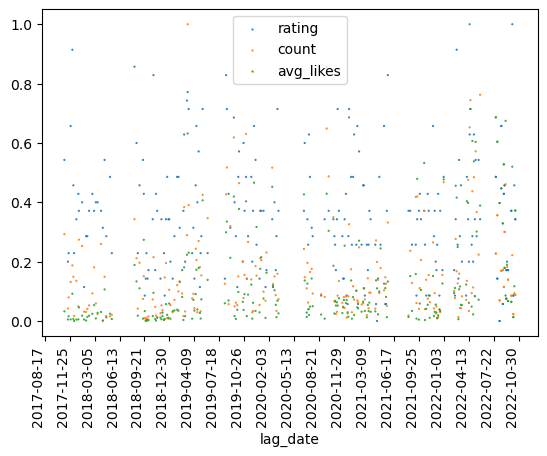

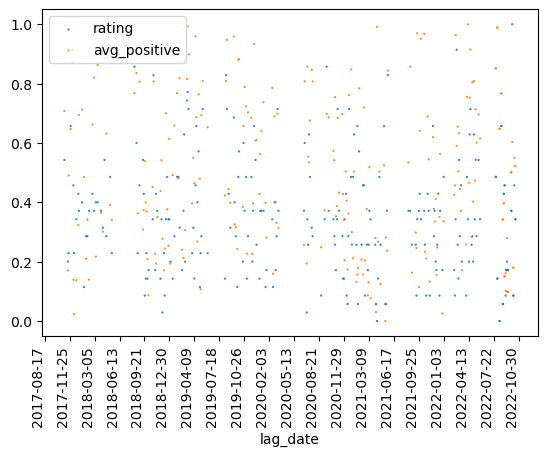

                 Unnamed: 0   minutes    rating  shotsTotal   shotsOn  \
Unnamed: 0         1.000000  0.124723  0.106605    0.107183 -0.101376   
minutes            0.124723  1.000000  0.322931    0.371778  0.257564   
rating             0.106605  0.322931  1.000000    0.408568  0.486962   
shotsTotal         0.107183  0.371778  0.408568    1.000000  0.751790   
shotsOn           -0.101376  0.257564  0.486962    0.751790  1.000000   
goals             -0.012960  0.158316  0.716334    0.411454  0.570489   
assists            0.114321  0.119509  0.235216    0.132227  0.082724   
passes            -0.007747  0.593917  0.473984    0.271408  0.230325   
tackles            0.099814  0.191758  0.187766   -0.031129 -0.024315   
blocks            -0.005662  0.089036  0.006082   -0.015512 -0.062273   
duelsTotal         0.136179  0.497606  0.173664    0.027517  0.001050   
duelsWon           0.086351  0.405614  0.316512    0.001584  0.008951   
foulsDrawn         0.045367  0.339589  0.209763    

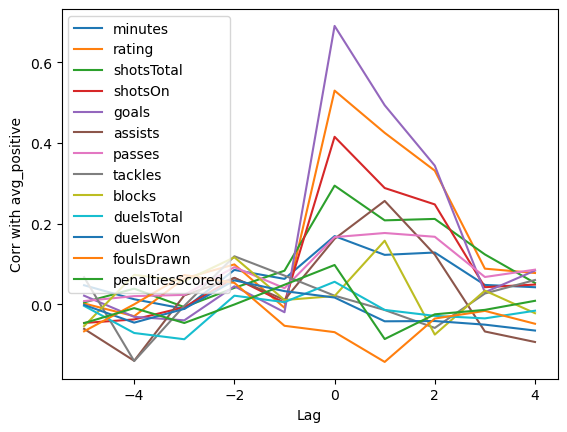

Rolling means by match days


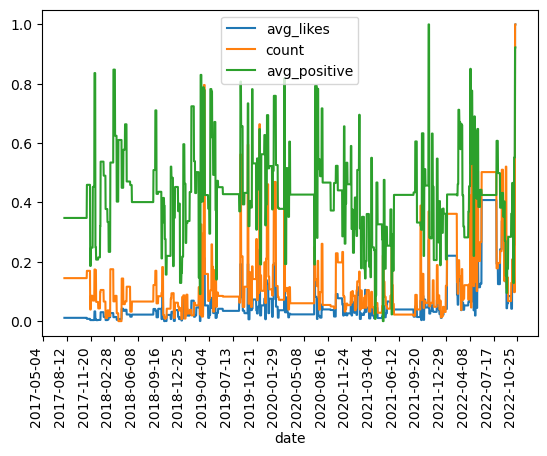

Trailing means by 30 days


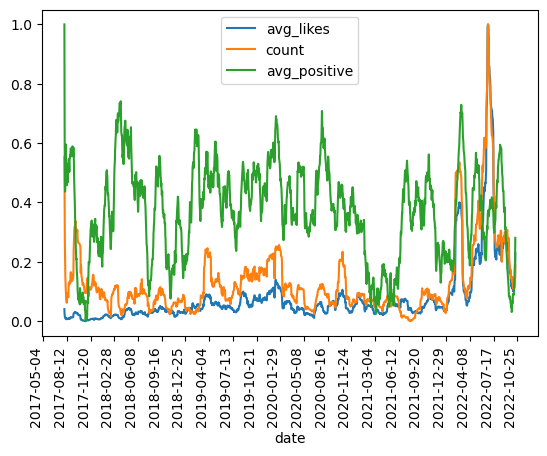

30 days seasonality for count


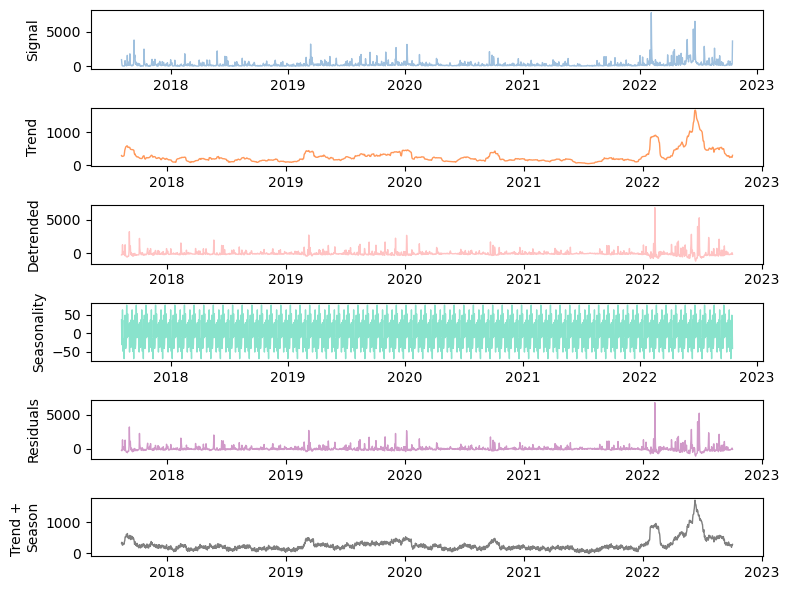

30 days seasonality for avg_positive


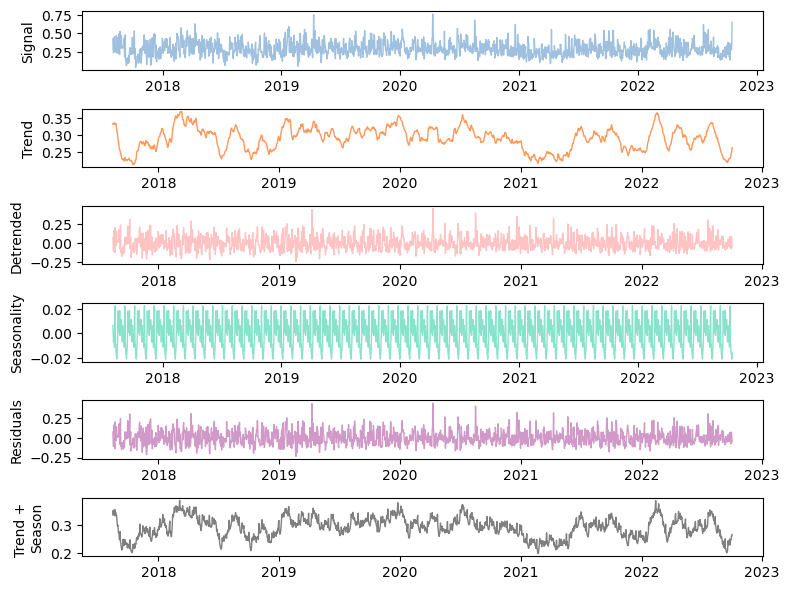

Traiing means by 365 days


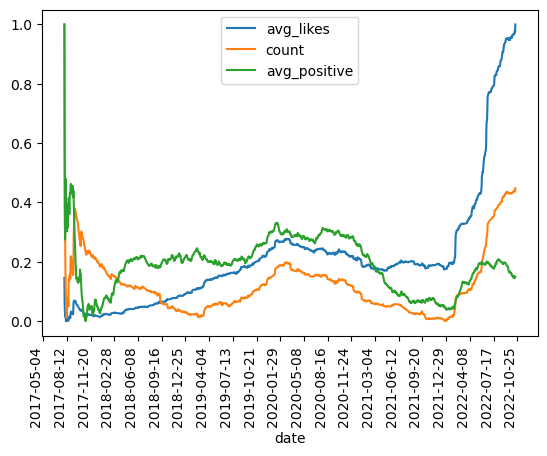

365 days seasonality for count


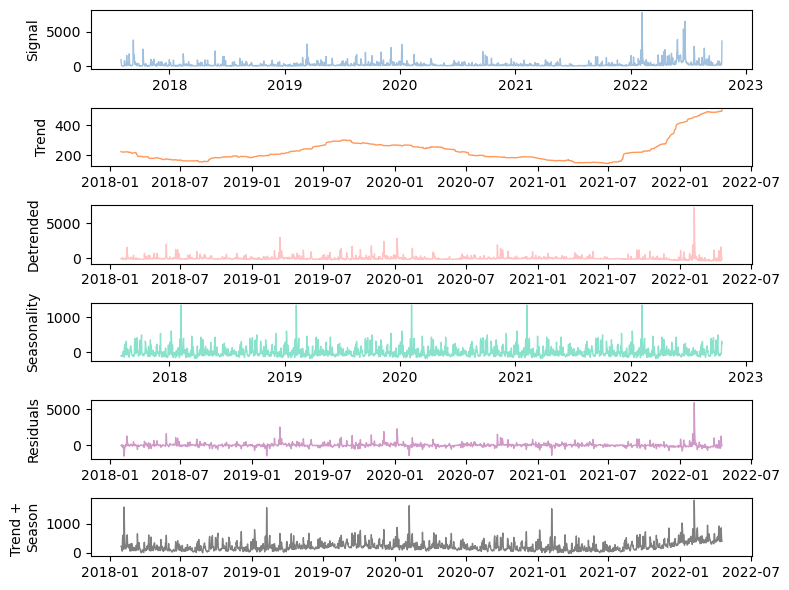

365 days seasonality for avg_positive


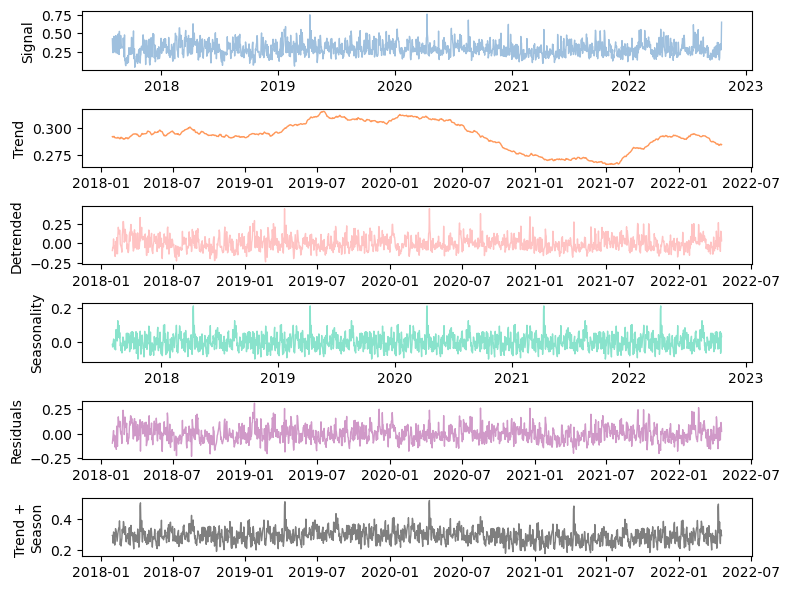

In [24]:
do_player_tweets_analysis("Sadio Mané") 

## Virgil van Dijk

raw shape:
 (139839, 8)


aggregated shape:
 (1904, 11)


raw describe:
                likes       negative        neutral       positive
count  139839.000000  139839.000000  139839.000000  139839.000000
mean       86.562790       0.180873       0.502273       0.316854
std       843.324408       0.234996       0.266521       0.319778
min         0.000000       0.000621       0.004639       0.002089
25%         0.000000       0.012965       0.280991       0.052240
50%         1.000000       0.059888       0.523713       0.156381
75%         6.000000       0.281906       0.730286       0.569036
max     83934.000000       0.981118       0.956397       0.993806


aggregated describe:
        total_tweets    avg_likes  avg_negative  avg_neutral  avg_positive  \
count   1904.000000  1904.000000   1904.000000  1904.000000   1904.000000   
mean      73.445903    69.052075      0.184171     0.503482      0.312347   
std       55.035308   121.462953      0.075878     0.082932      0.103070   
m

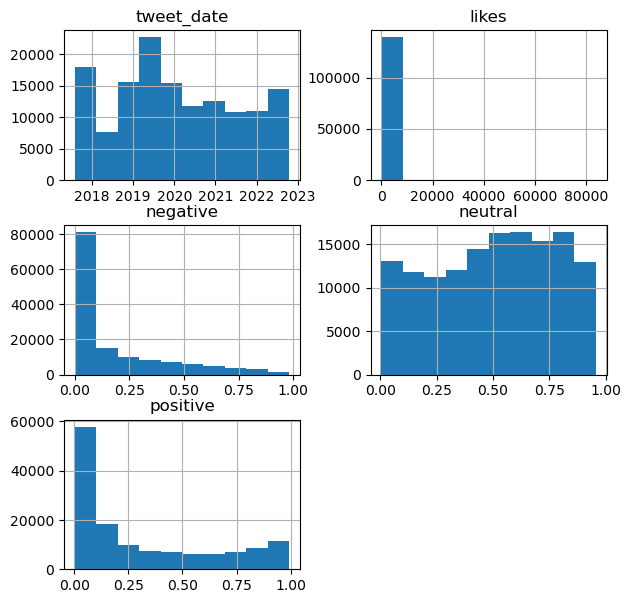

aggregated distributions:


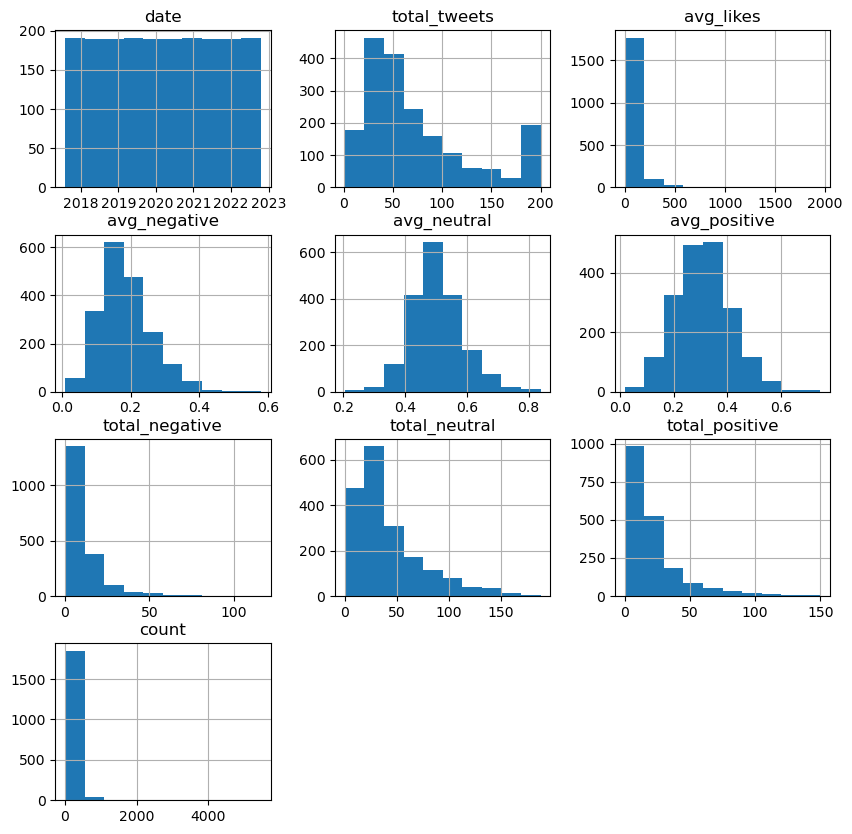

raw correlations:
             likes  negative   neutral  positive
likes     1.000000 -0.015244 -0.018985  0.027025
negative -0.015244  1.000000 -0.191583 -0.575197
neutral  -0.018985 -0.191583  1.000000 -0.692665
positive  0.027025 -0.575197 -0.692665  1.000000


aggregated corr:
                total_tweets  avg_likes  avg_negative  avg_neutral  \
total_tweets        1.000000   0.192479     -0.057942    -0.019505   
avg_likes           0.192479   1.000000     -0.001849    -0.128491   
avg_negative       -0.057942  -0.001849      1.000000    -0.159860   
avg_neutral        -0.019505  -0.128491     -0.159860     1.000000   
avg_positive        0.058351   0.104748     -0.607558    -0.686936   
total_negative      0.643993   0.163902      0.534045    -0.157727   
total_neutral       0.921796   0.107997     -0.075881     0.279514   
total_positive      0.772120   0.232439     -0.316841    -0.388157   
count               0.584671   0.339602     -0.046980     0.001450   

                a

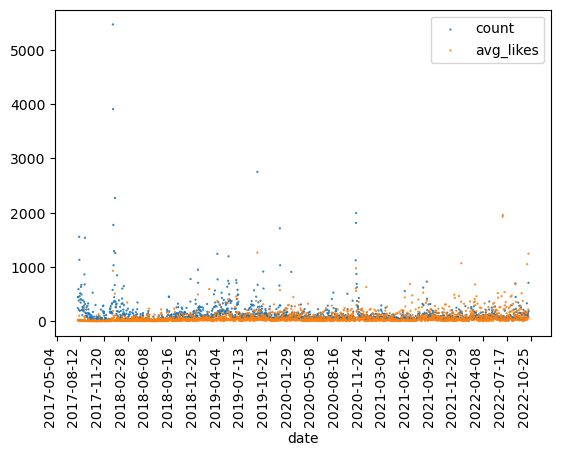

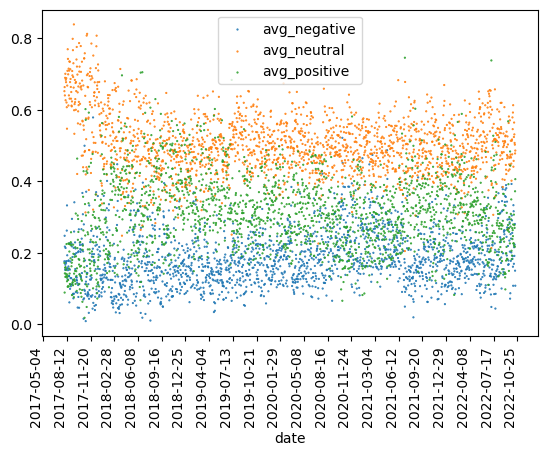

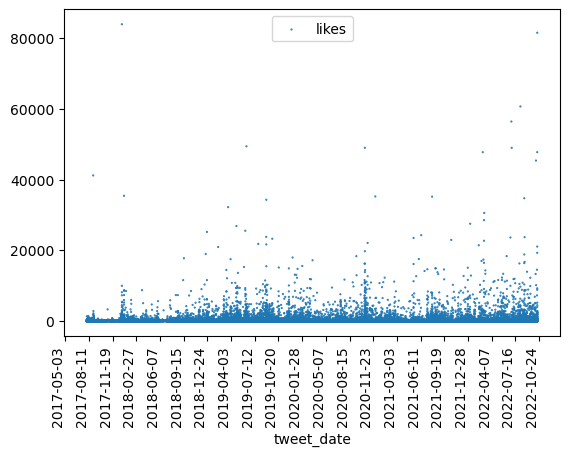

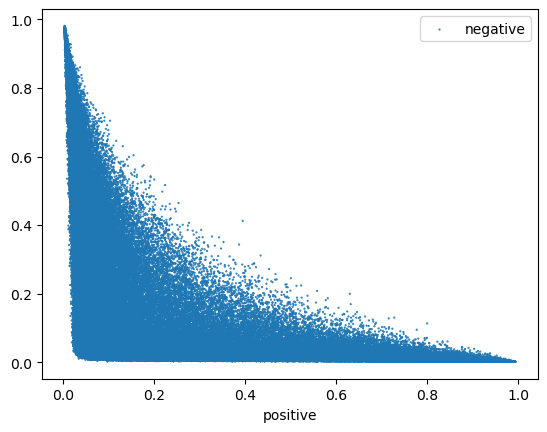

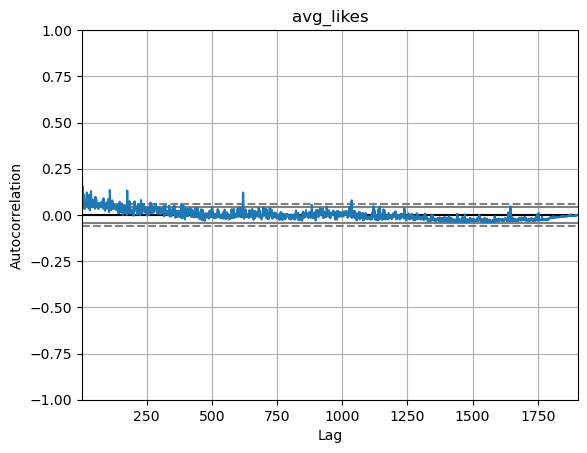

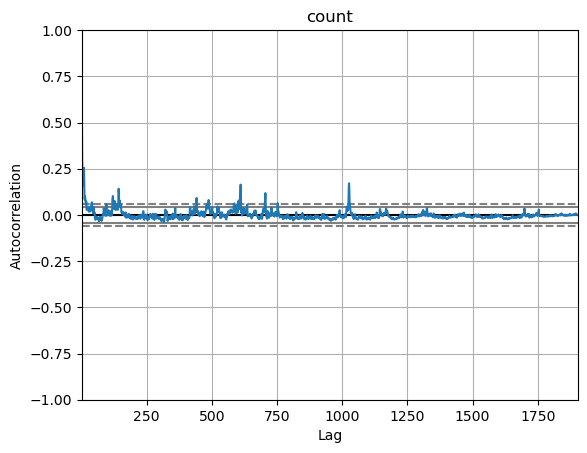

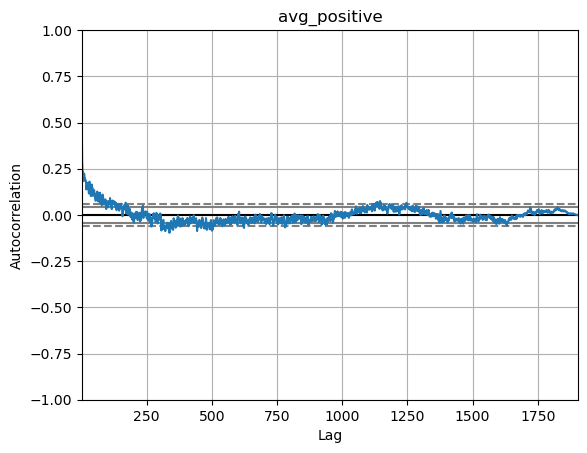

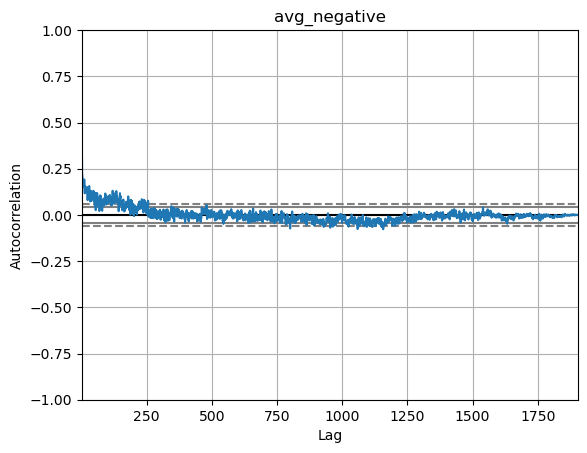

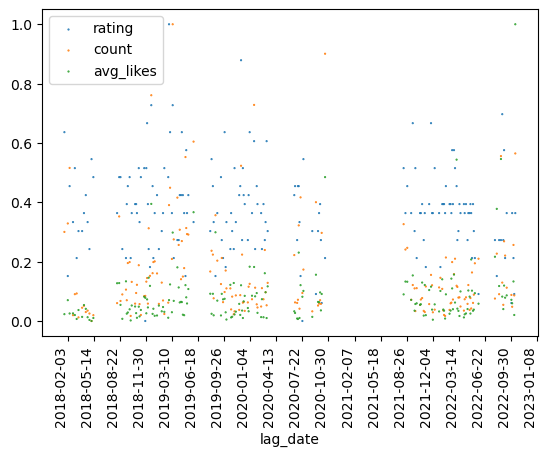

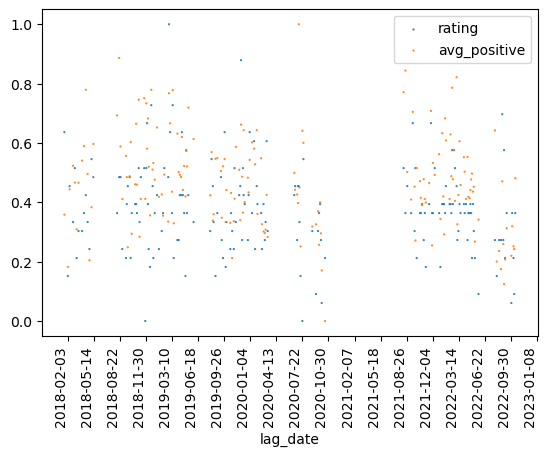

                 Unnamed: 0   minutes    rating  shotsTotal   shotsOn  \
Unnamed: 0         1.000000  0.024788  0.104092    0.058581 -0.054209   
minutes            0.024788  1.000000  0.076979    0.096002  0.072942   
rating             0.104092  0.076979  1.000000    0.233019  0.343612   
shotsTotal         0.058581  0.096002  0.233019    1.000000  0.542477   
shotsOn           -0.054209  0.072942  0.343612    0.542477  1.000000   
goals              0.018670  0.015887  0.522064    0.198000  0.479886   
assists            0.110228  0.011557  0.218945    0.066872  0.081950   
passes            -0.121868  0.257733  0.236196    0.058193  0.024342   
tackles            0.201911 -0.007709  0.180990   -0.022533 -0.012766   
blocks            -0.077971  0.032872  0.023760   -0.082093 -0.060911   
duelsTotal         0.232582  0.074785  0.246264    0.071098  0.069028   
duelsWon           0.209313  0.078331  0.354805    0.094298  0.108879   
foulsDrawn         0.255814  0.092078  0.073929   -

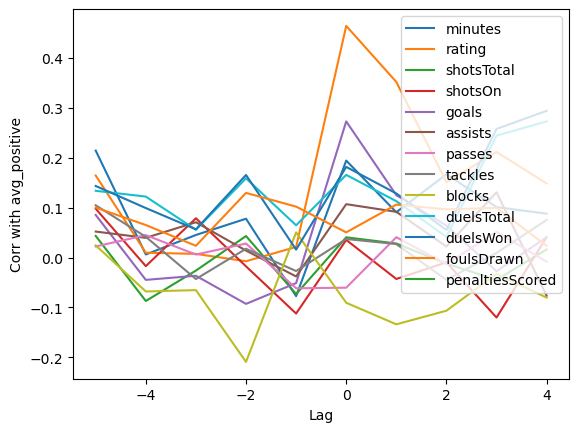

Rolling means by match days


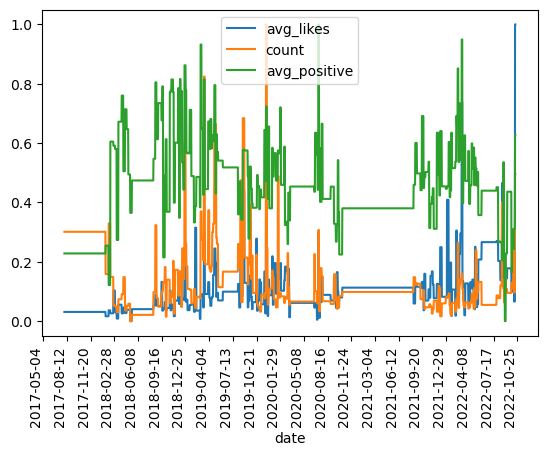

Trailing means by 30 days


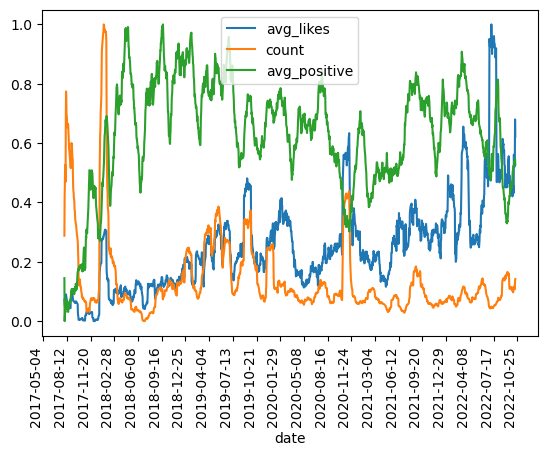

30 days seasonality for count


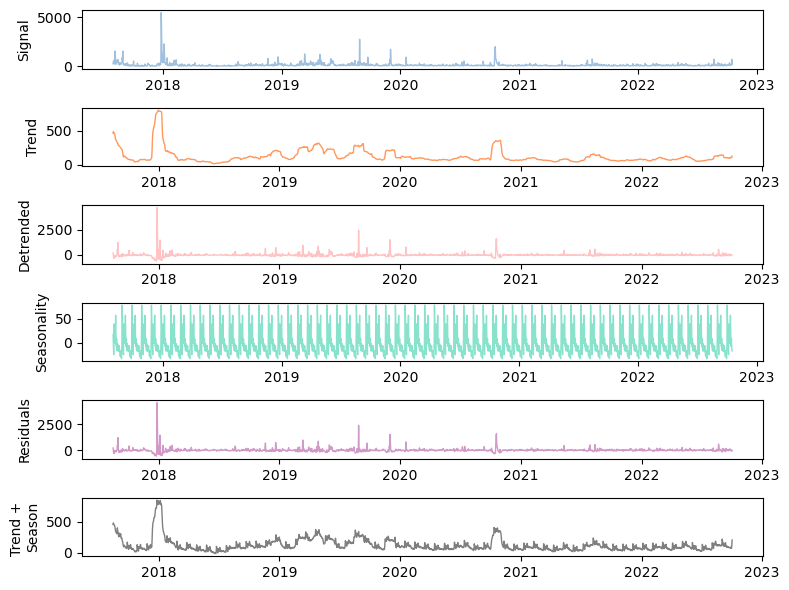

30 days seasonality for avg_positive


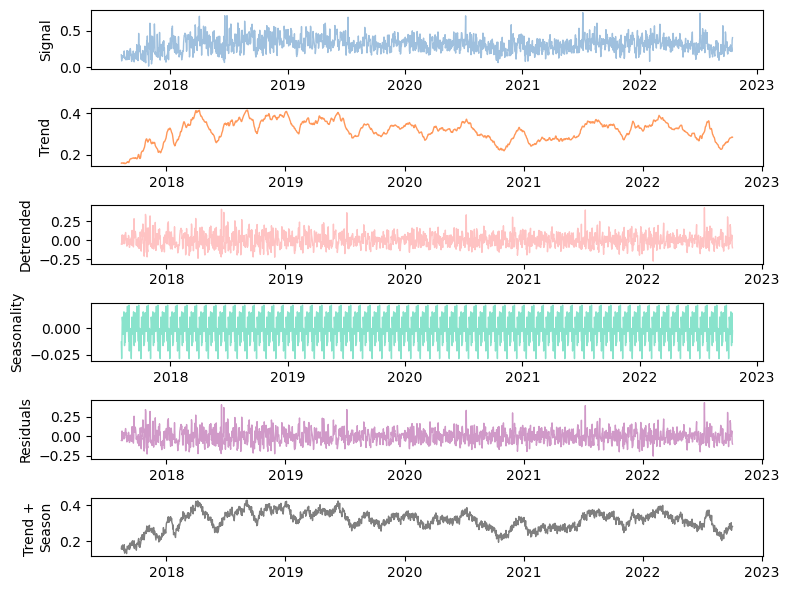

Traiing means by 365 days


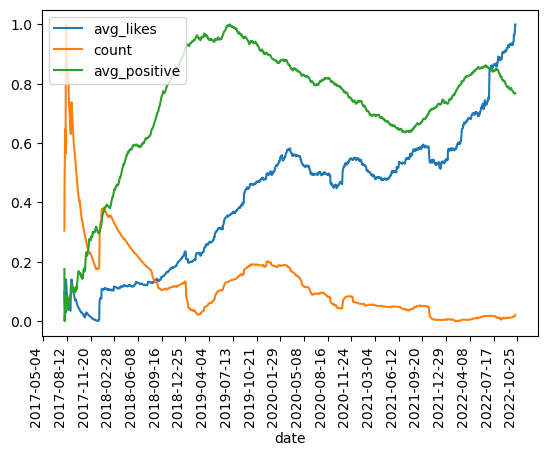

365 days seasonality for count


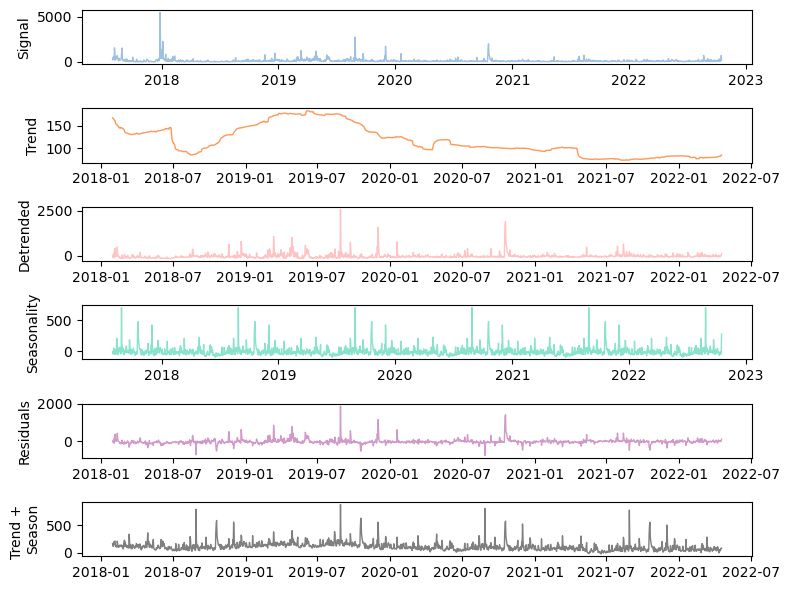

365 days seasonality for avg_positive


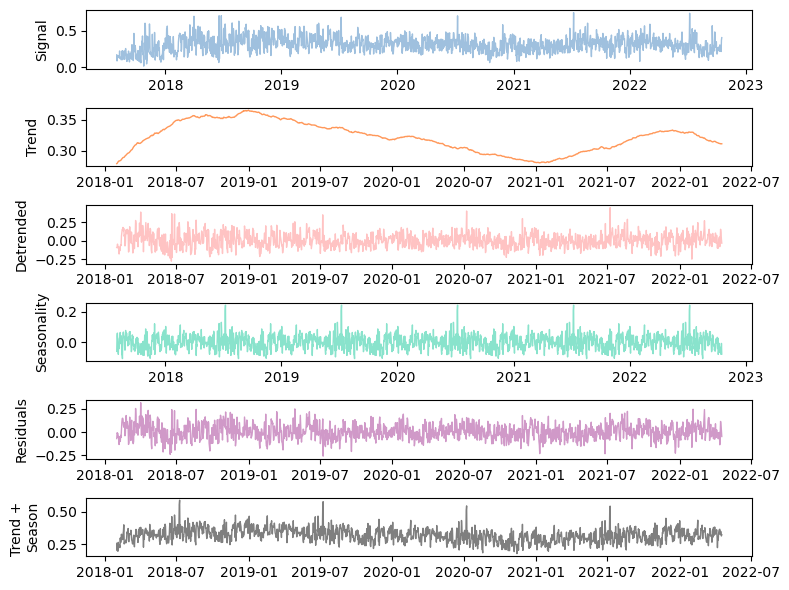

In [25]:
do_player_tweets_analysis("Virgil van Dijk") 